In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wrangle_data as wd
from pandas.api.types import CategoricalDtype
import get_metrics as gm
import datetime
import seaborn as sns
from math import ceil

%matplotlib inline

Main data frames

In [2]:
df = wd.run()
df_c = wd.merge_complex(df)
df_s = wd.merge_spt(df)
spt = wd.spt()

In [4]:
df_c.columns

Index(['datetime', 'c_a', 'unit', 'scp', 'station_x', 'linename', 'division',
       'desc', 'entries', 'exits', 'tuid', 'suid', 'buid', 'ts_count',
       'net_entries', 'net_exits', 'traffic', 'booth', 'complex_id',
       'station_y', 'line_name'],
      dtype='object')

In [3]:
dens = df_c[['complex_id', 'station_x', 'suid', 'tuid', 'datetime', 'traffic']]

#if we're looking at a whole day, ignoring traffic counts under 0 simplifies the data
# dens = dens[(dens['traffic']>0)] 

#Round each datetime stamp to closest hour to make plotting much more simple
#Seriously this step reduces unique datetime values from ~11500 to 165
#for some reason the round function is only available for a datetime index
dens = dens.set_index('datetime') 
dens.index = dens.index.round('H')
dens.reset_index(inplace=True)

dens['delta_time'] = dens.groupby(['suid', 'tuid'])['datetime'].diff().dt.seconds.shift(-1) / 3600
#drop the nulls that were created in the above step
dens = dens.dropna()

# dens['date'] = dens['date'].dt.date
# dens['time'] = dens['datetime'].dt.time

#if delta_time is 0, that's an error, plus it'll mess up the next step
dens = dens[(dens['complex_id'] > 0) & (dens['delta_time'] > 0)]

#Calculate average traffic per hour at each turnstile in each time interval 
dens['trf_hr'] = dens['traffic'] / dens['delta_time']

#Calculate total traffic per hour per station in each time interval 
dens_traffic_station_hr = dens.groupby(['suid', 'datetime'])['trf_hr'].sum().reset_index()
dens_traffic_station_hr.rename(columns = {'trf_hr': 'total_traffic'}, inplace=True)
dens = dens.merge(dens_traffic_station_hr, on=['suid', 'datetime'], how='left')

#Calculate average traffic per hour per station for each time interval 
dens_traffic_station_min = dens.groupby(['suid', 'datetime'])['trf_hr'].mean().reset_index()
dens_traffic_station_min.rename(columns = {'trf_hr': 'avg_traffic'}, inplace=True)
dens = dens.merge(dens_traffic_station_min, on=['suid', 'datetime'], how='left')


In [5]:
dens_stats = dens[[*dens.columns[0:4],*dens.columns[8:]]].drop_duplicates()


dens_stats_st = dens_stats.set_index('suid')
st_stats = {}
for st in dens_stats_st.index.unique():
    st_stats[dens_stats_st['station_x'][st].unique()[0]] = \
    dens_stats_st[dens_stats_st.index == st].reset_index(drop=True)
    

In [ ]:
#Total traffic per hour per turnstile in a station, plotted in station subplots
col_nums = 10  # how many plots per row
row_nums = ceil(len(st_stats) / col_nums)  # how many rows of plots
plt.figure(figsize=(40,100))  # change the figure size as needed
for i, (k, v) in enumerate(st_stats.items(), 1):
    plt.subplot(row_nums, col_nums, i)  # create subplots
    sub_v = v['total_traffic']
    p = plt.stem(sub_v, markerfmt=' ', use_line_collection=True)
    plt.title(f'Station: {k}')
    plt.ylabel('Total traffic/hour for all ts in station')

plt.tight_layout()
plt.show()


In [ ]:
#Average traffic per hour per turnstile in a station, plotted in station subplots
col_nums = 10  # how many plots per row
row_nums = ceil(len(st_stats) / col_nums)  # how many rows of plots
plt.figure(figsize=(40,100))  # change the figure size as needed
for i, (k, v) in enumerate(st_stats.items(), 1):
    plt.subplot(row_nums, col_nums, i)  # create subplots
    sub_v = v['avg_traffic']
    p = plt.stem(sub_v, markerfmt=' ', use_line_collection=True)
    plt.title(f'Station: {k}')
    plt.ylabel('Average traffic/hour for all ts in station')

plt.tight_layout()
plt.show()


In [6]:
dens_stats_time = dens_stats.set_index('datetime')

dens_stats_time_tot = dens_stats_time.groupby('suid')['total_traffic'].sum().to_dict()
dens_stats_time['tot_traffic_wk'] = dens_stats_time.suid.map(dens_stats_time_tot)

dens_stats_time_avg = dens_stats_time.groupby('suid')['avg_traffic'].mean().to_dict()
dens_stats_time['avg_traffic_wk'] = dens_stats_time.suid.map(dens_stats_time_avg)

dst_tot = dens_stats_time.reset_index().sort_values(['datetime','tot_traffic_wk']).set_index('datetime')
dst_avg = dens_stats_time.reset_index().sort_values(['datetime','avg_traffic_wk']).set_index('datetime')

In [7]:
time_stats = {}
for ti in dst_tot.index.unique():
    if (dst_tot[dst_tot.index == ti]['suid'].nunique() > 10):
        time_stats[ti] = dst_tot[dst_tot.index == ti].reset_index(drop=True)

In [ ]:
#Total traffic per hour in a station, plotted in datetime slots, w/
# stations sorted by total weekly traffic per hour
col_nums = 5  # how many plots per row
row_nums = ceil(len(time_stats) / col_nums)  # how many rows of plots
plt.figure(figsize=(40,100))  # change the figure size as needed
for i, (k, v) in enumerate(time_stats.items(), 1):
    plt.subplot(row_nums, col_nums, i)  # create subplots
    sub_v = v['total_traffic']
    p = plt.stem(sub_v, markerfmt=' ', use_line_collection=True)
    plt.title(k)
    plt.ylabel('Traffic/station/hr')
    plt.xlabel('Stations sorted by tot traffic/week')

plt.tight_layout()
plt.show()


In [ ]:
#Average traffic per hour per turnstile in a station, plotted in datetime slots, w/
# stations sorted by total weekly traffic
col_nums = 5  # how many plots per row
row_nums = ceil(len(time_stats) / col_nums)  # how many rows of plots
plt.figure(figsize=(40,100))  # change the figure size as needed
for i, (k, v) in enumerate(time_stats.items(), 1):
    plt.subplot(row_nums, col_nums, i)  # create subplots
    sub_v = v['avg_traffic']
    p = plt.stem(sub_v, markerfmt=' ', use_line_collection=True)
    plt.title(k)
    plt.ylabel('Traffic/station/hr/ts')
    plt.xlabel('Stations sorted by tot traffic/week')

plt.tight_layout()
plt.show()


In [1183]:
time_stats_avg = {}
for ti in dst_avg.index.unique():
    if (dst_avg[dst_avg.index == ti]['suid'].nunique() > 10):
        time_stats_avg[ti] = dst_avg[dst_avg.index == ti].reset_index(drop=True)

In [ ]:
#Total traffic per hour in a station, plotted in datetime slots, w/
# stations sorted by average weekly traffic per hour
col_nums = 5  # how many plots per row
row_nums = ceil(len(time_stats_avg) / col_nums)  # how many rows of plots
plt.figure(figsize=(40,100))  # change the figure size as needed
for i, (k, v) in enumerate(time_stats_avg.items(), 1):
    plt.subplot(row_nums, col_nums, i)  # create subplots
    sub_v = v['total_traffic']
    p = plt.stem(sub_v, markerfmt=' ', use_line_collection=True)
    plt.title(k)
    plt.ylabel('Traffic/station/hr')
    plt.xlabel('Stations sorted by avg traffic/hr')

plt.tight_layout()
plt.show()


In [ ]:
#Average traffic per hour per turnstile in a station, plotted in datetime slots, w/
# stations sorted by average weekly traffic per hour
col_nums = 5  # how many plots per row
row_nums = ceil(len(time_stats_avg) / col_nums)  # how many rows of plots
plt.figure(figsize=(40,100))  # change the figure size as needed
for i, (k, v) in enumerate(time_stats_avg.items(), 1):
    plt.subplot(row_nums, col_nums, i)  # create subplots
    sub_v = v['avg_traffic']
    p = plt.stem(sub_v, markerfmt=' ', use_line_collection=True)
    plt.title(k)
    plt.ylabel('Traffic/station/hr/ts')
    plt.xlabel('Stations sorted by avg traffic/hr')

plt.tight_layout()
plt.show()


In [8]:
dens2 = df_c[['complex_id', 'station_x', 'suid', 'tuid', 'datetime', 'traffic', 'ts_count']]

#if we're looking at a whole day, ignoring traffic counts under 0 simplifies the data
# dens = dens[(dens['traffic']>0)] 

#Round each datetime stamp to closest hour to make plotting much more simple
#Seriously this step reduces unique datetime values from ~11500 to 165
#for some reason the round function is only available for a datetime index
dens2 = dens2.set_index('datetime') 
dens2.index = dens2.index.round('2H')
dens2.reset_index(inplace=True)

dens2['delta_time'] = dens2.groupby(['suid', 'tuid'])['datetime'].diff().dt.seconds.shift(-1) / 3600
#drop the nulls that were created in the above step
dens2 = dens2.dropna()

#if delta_time is 0, that's an error, plus it'll mess up the next step
dens2 = dens2[(dens2['complex_id'] > 0) & (dens2['delta_time'] > 0)]

#Calculate average traffic per hour at each turnstile in each time interval 
dens2['trf_hr'] = dens2['traffic'] / dens2['delta_time']

# dens['date'] = dens['date'].dt.date
dens2['time'] = dens2['datetime'].dt.time

#Calculate total traffic per hour per station in each time interval 
dens2_traffic_station_hr = dens2.groupby(['suid', 'datetime'])['trf_hr'].sum().reset_index()
dens2_traffic_station_hr.rename(columns = {'trf_hr': 'total_traffic'}, inplace=True)
dens2 = dens2.merge(dens2_traffic_station_hr, on=['suid', 'datetime'], how='left')

#Calculate average traffic per hour per station for each time interval 
dens2_traffic_station_min = dens2.groupby(['suid', 'datetime'])['trf_hr'].mean().reset_index()
dens2_traffic_station_min.rename(columns = {'trf_hr': 'avg_traffic'}, inplace=True)
dens2 = dens2.merge(dens2_traffic_station_min, on=['suid', 'datetime'], how='left')

In [9]:
dens2_stats = dens2[[*dens2.columns[0:4],*dens2.columns[8:]]].drop_duplicates()

#aggregate by day, separating weekend
dens2_stats['week_end'] = dens2_stats['datetime'].dt.dayofweek.apply(lambda x: 'weekend' if  x >= 5 else 'week')
dens2_stats = dens2_stats.groupby(['suid', 'week_end', 'time'])[['total_traffic', 'avg_traffic']].sum().reset_index()

In [10]:
dst2 = dens2_stats.set_index(['week_end', 'time'])

dst2_tot_dict = dst2.groupby('suid')['total_traffic'].sum().to_dict()
dst2['tot_traffic_wk'] = dst2.suid.map(dst2_tot_dict)

dst2_avg_dict = dst2.groupby('suid')['avg_traffic'].mean().to_dict()
dst2['avg_traffic_wk'] = dst2.suid.map(dst2_avg_dict)

dst2_tot = dst2.sort_values('tot_traffic_wk').sort_index()
dst2_avg = dst2.sort_values('avg_traffic_wk').sort_index()

In [11]:
dst2_tot_wk = dst2_tot.loc['week']
dst2_tot_wknd = dst2_tot.loc['weekend']
dst2_avg_wk = dst2_avg.loc['week']
dst2_avg_wknd = dst2_avg.loc['weekend']

In [1225]:
tst2_wk = {}
for ti in dst2_tot_wk.index.unique():
    if (dst2_tot_wk[dst2_tot_wk.index == ti]['suid'].nunique() > 20):
        tst2_wk[ti.isoformat()] = dst2_tot_wk[dst2_tot_wk.index == ti].reset_index(drop=True)

In [1231]:
tst2_wk_avg = {}
for ti in dst2_avg_wk.index.unique():
    if (dst2_avg_wk[dst2_avg_wk.index == ti]['suid'].nunique() > 20):
        tst2_wk_avg[ti.isoformat()] = dst2_avg_wk[dst2_avg_wk.index == ti].reset_index(drop=True)

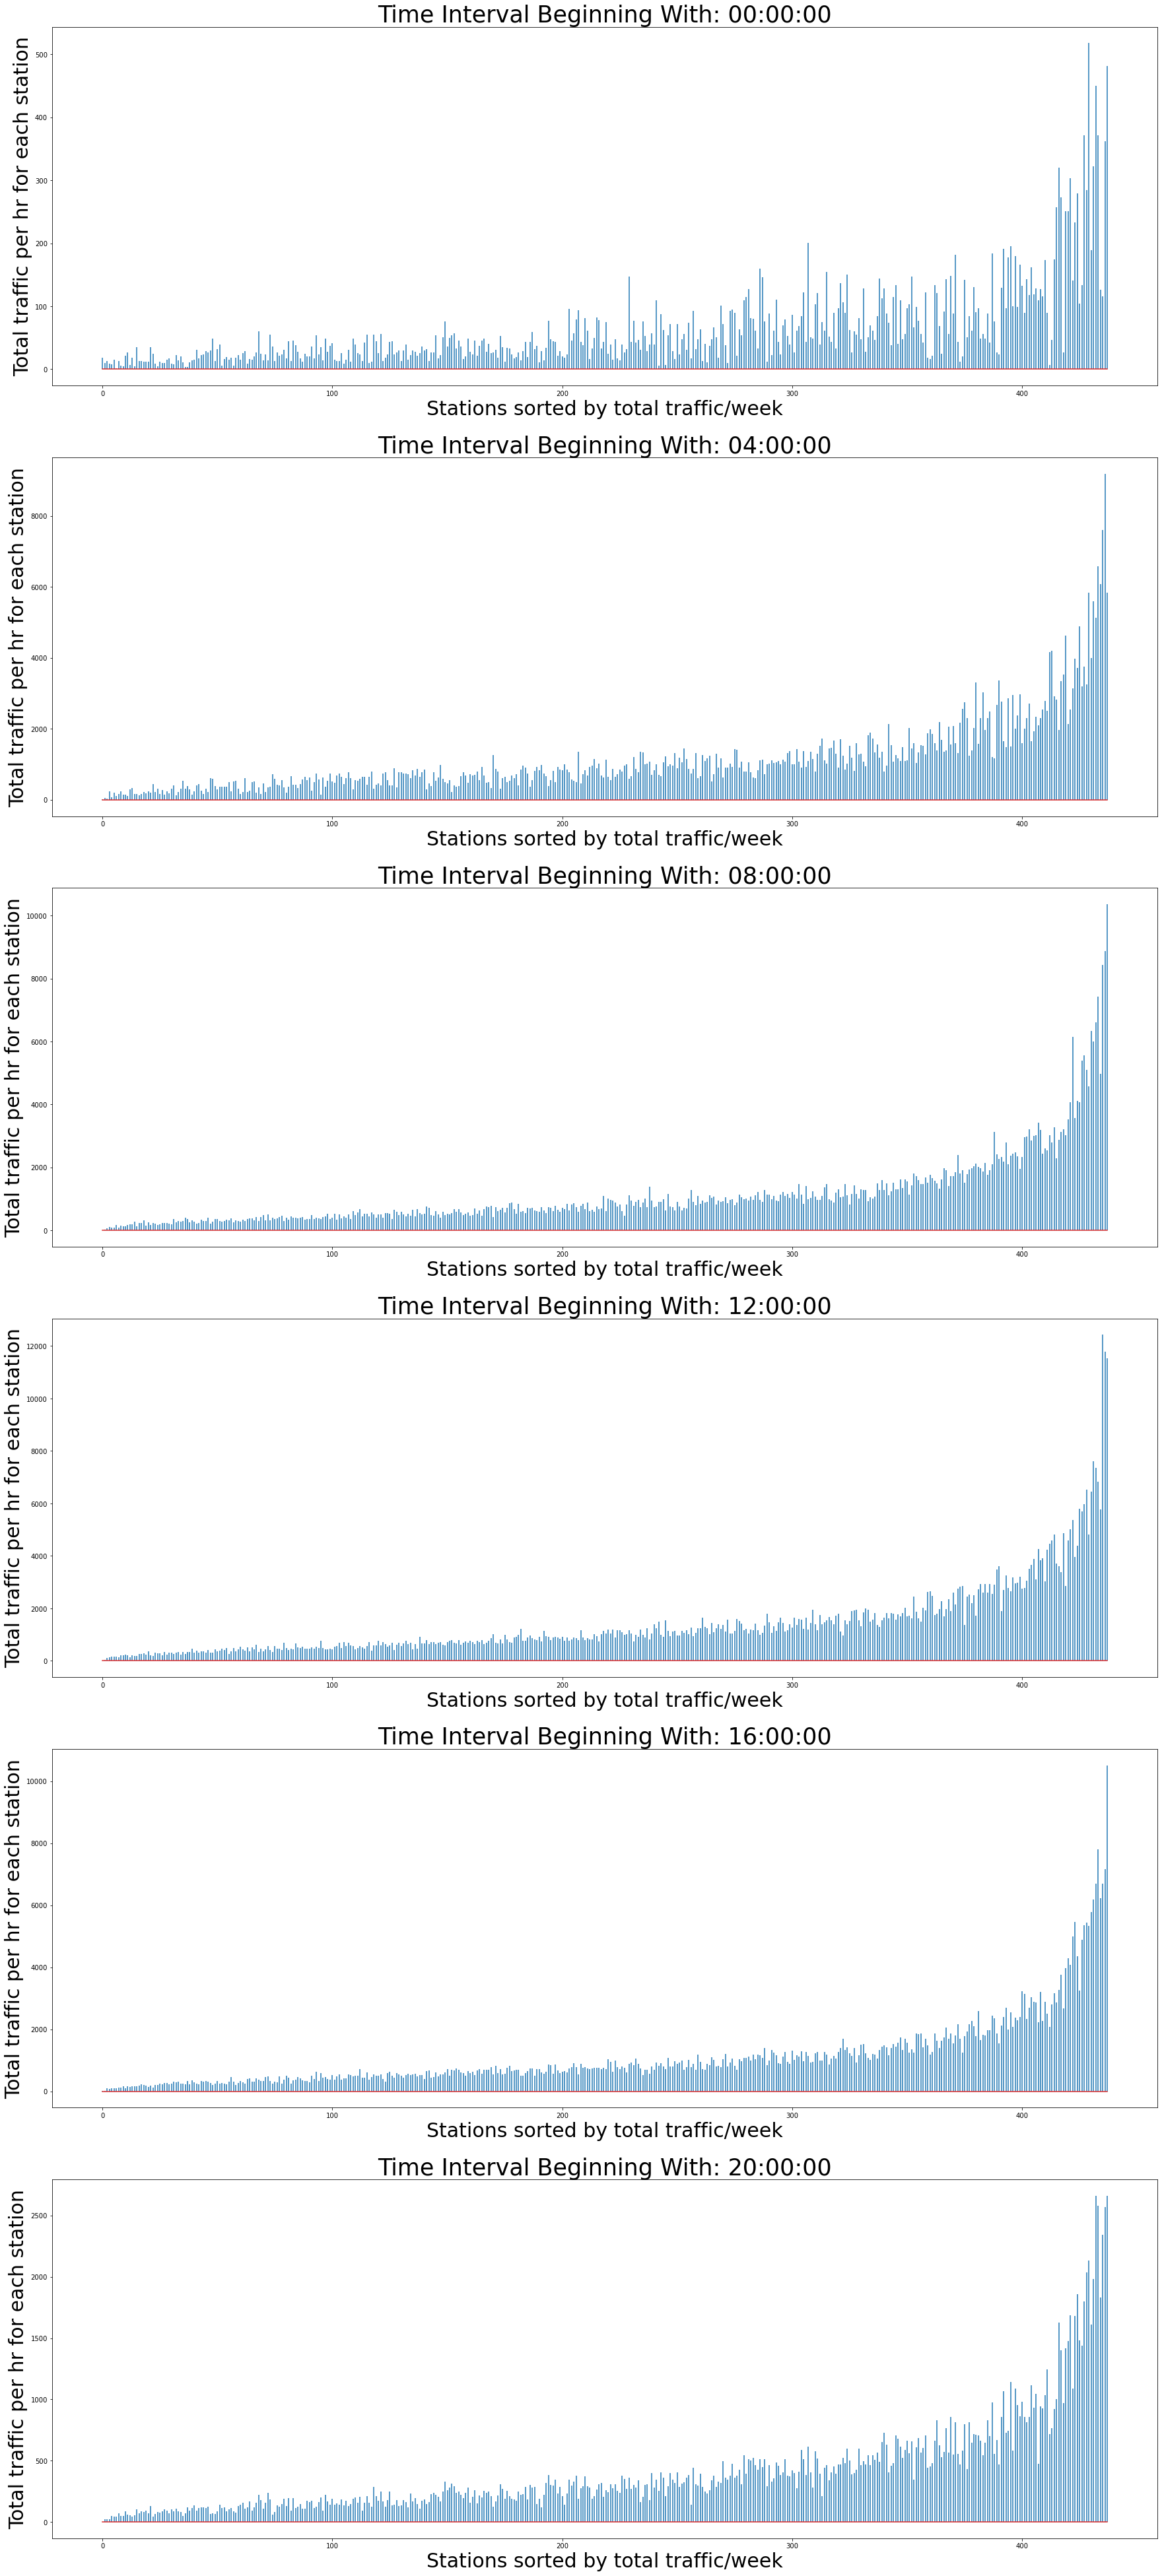

In [1227]:
#Total traffic per hour in a station, plotted in datetime slots, w/
# stations sorted by total weekly traffic per hour
col_nums = 1  # how many plots per row
row_nums = ceil(len(tst2_wk) / col_nums)  # how many rows of plots
plt.figure(figsize=(30,70))  # change the figure size as needed
for i, (k, v) in enumerate(tst2_wk.items(), 1):
    plt.subplot(row_nums, col_nums, i)  # create subplots
    sub_v = v['total_traffic']
    p = plt.stem(sub_v, markerfmt=' ', use_line_collection=True)
    plt.title(f'Time Interval Beginning With: {k}', fontsize = 35)
    plt.ylabel('Total traffic per hr for each station', fontsize = 30)
    plt.xlabel('Stations sorted by total traffic/week', fontsize = 30)

# plt.tight_layout()
plt.show()


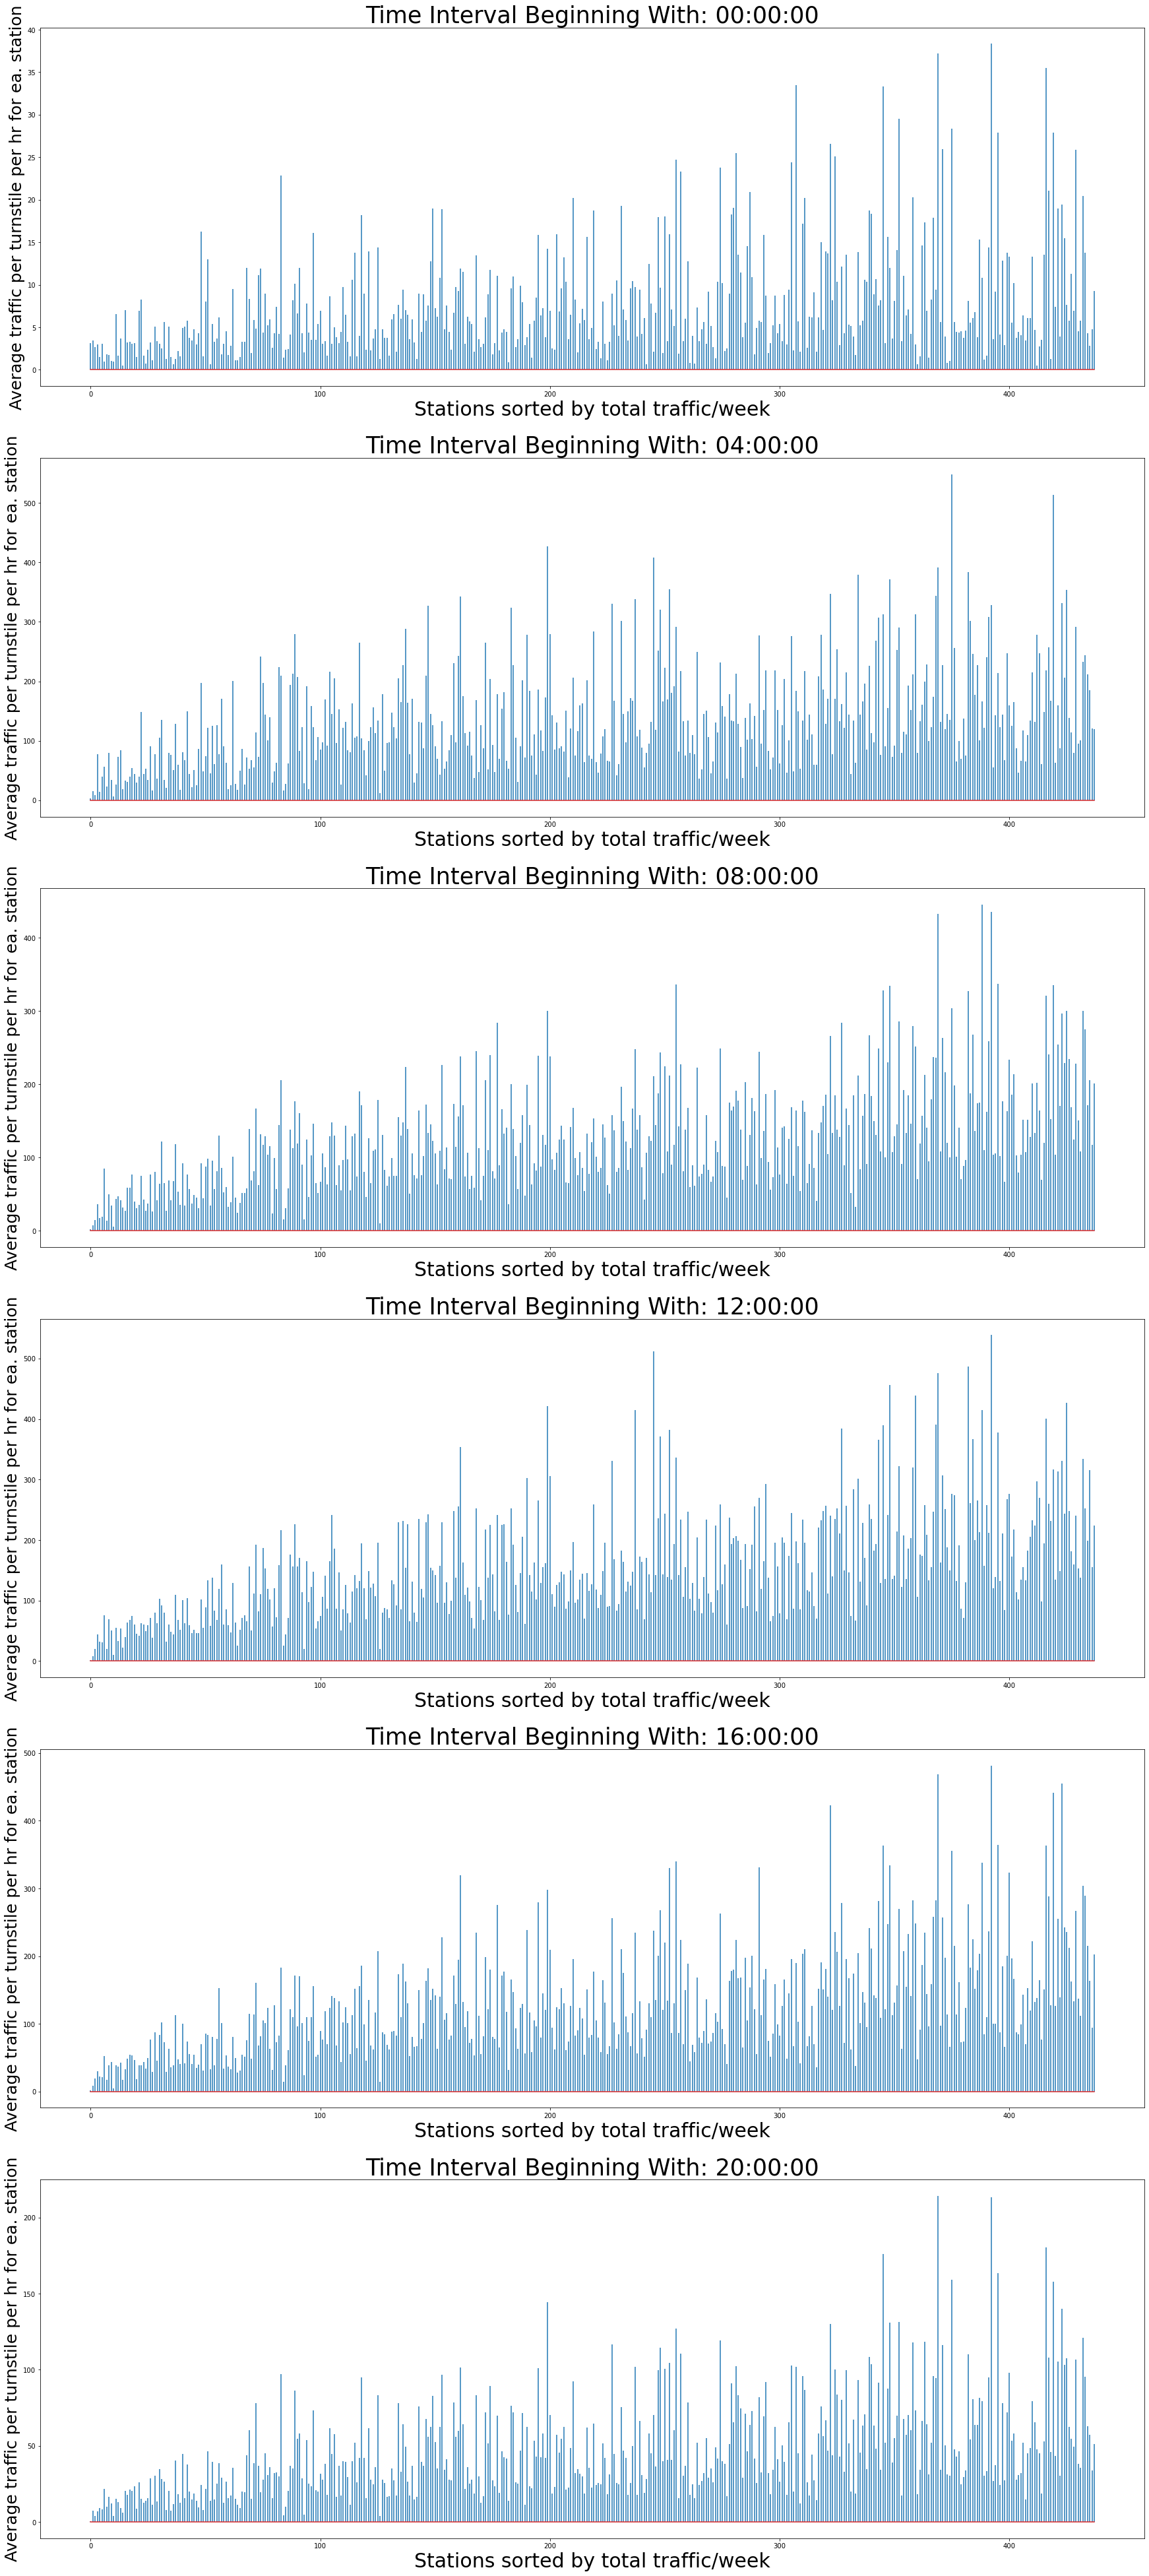

In [1228]:
#Average traffic per hour per turnstile in a station, plotted in datetime slots, w/
# stations sorted by total weekly traffic
col_nums = 1  # how many plots per row
row_nums = ceil(len(tst2_wk) / col_nums)  # how many rows of plots
plt.figure(figsize=(30,70))  # change the figure size as needed
for i, (k, v) in enumerate(tst2_wk.items(), 1):
    plt.subplot(row_nums, col_nums, i)  # create subplots
    sub_v = v['avg_traffic']
    p = plt.stem(sub_v, markerfmt=' ', use_line_collection=True)
    plt.title(f'Time Interval Beginning With: {k}', fontsize=35)
    plt.ylabel('Average traffic per turnstile per hr for ea. station', fontsize = 25)
    plt.xlabel('Stations sorted by total traffic/week', fontsize = 30)

# plt.tight_layout()
plt.show()


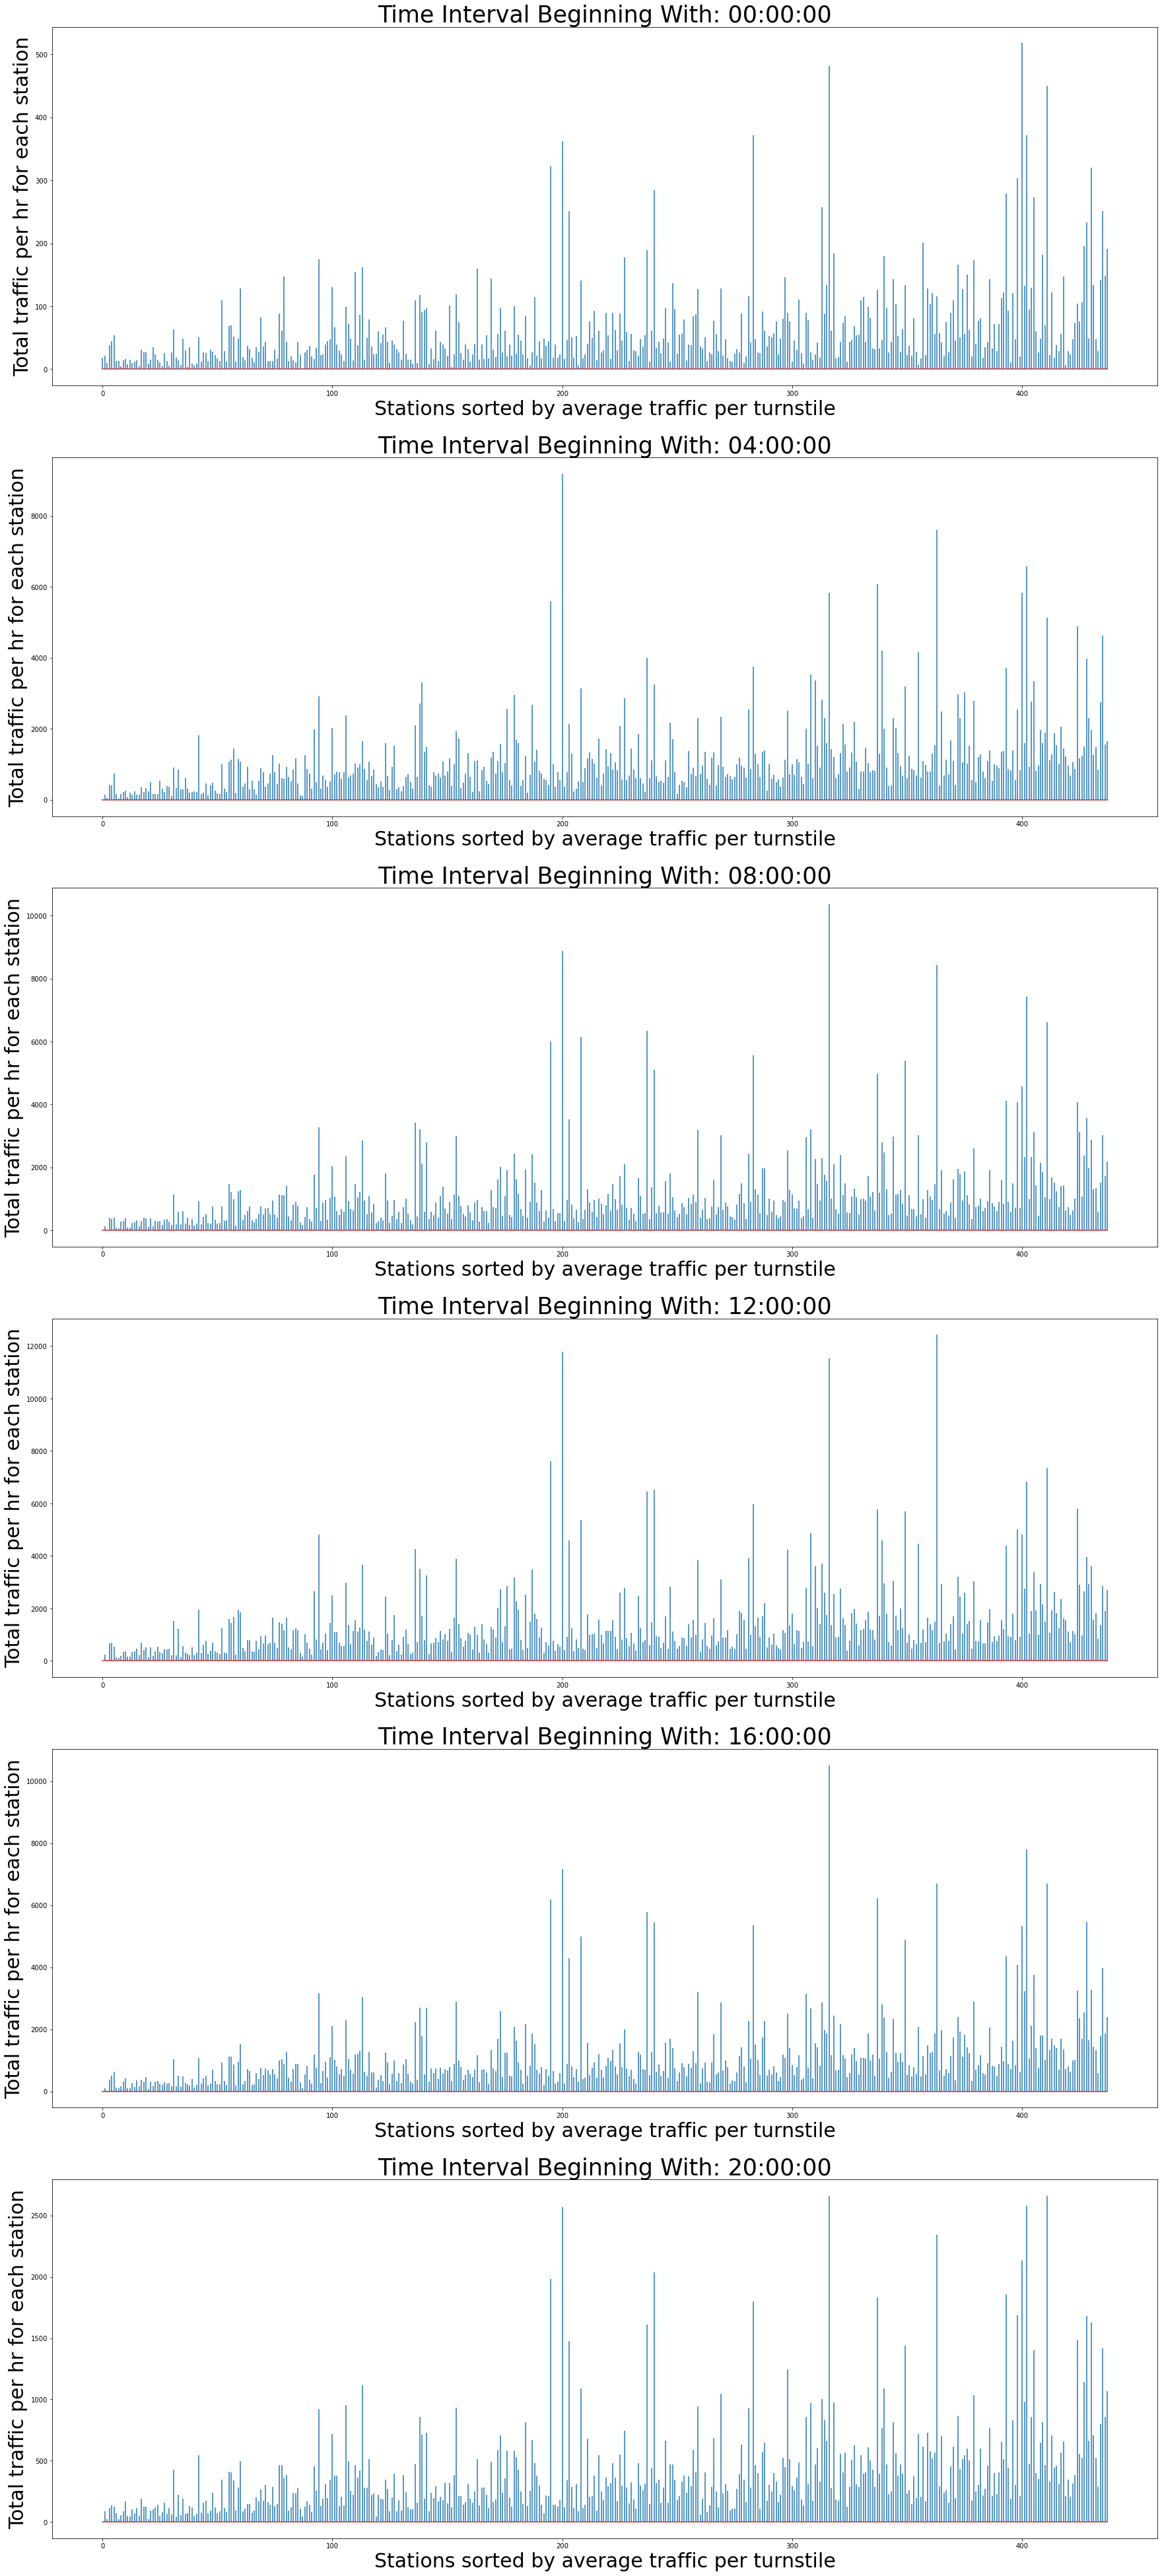

In [1232]:
#Total traffic per hour in a station, plotted in datetime slots, w/
# stations sorted by total weekly traffic per hour
col_nums = 1  # how many plots per row
row_nums = ceil(len(tst2_wk_avg) / col_nums)  # how many rows of plots
plt.figure(figsize=(30,70))  # change the figure size as needed
for i, (k, v) in enumerate(tst2_wk_avg.items(), 1):
    plt.subplot(row_nums, col_nums, i)  # create subplots
    sub_v = v['total_traffic']
    p = plt.stem(sub_v, markerfmt=' ', use_line_collection=True)
    plt.title(f'Time Interval Beginning With: {k}', fontsize = 35)
    plt.ylabel('Total traffic per hr for each station', fontsize = 30)
    plt.xlabel('Stations sorted by average traffic per turnstile', fontsize = 30)

# plt.tight_layout()
plt.show()


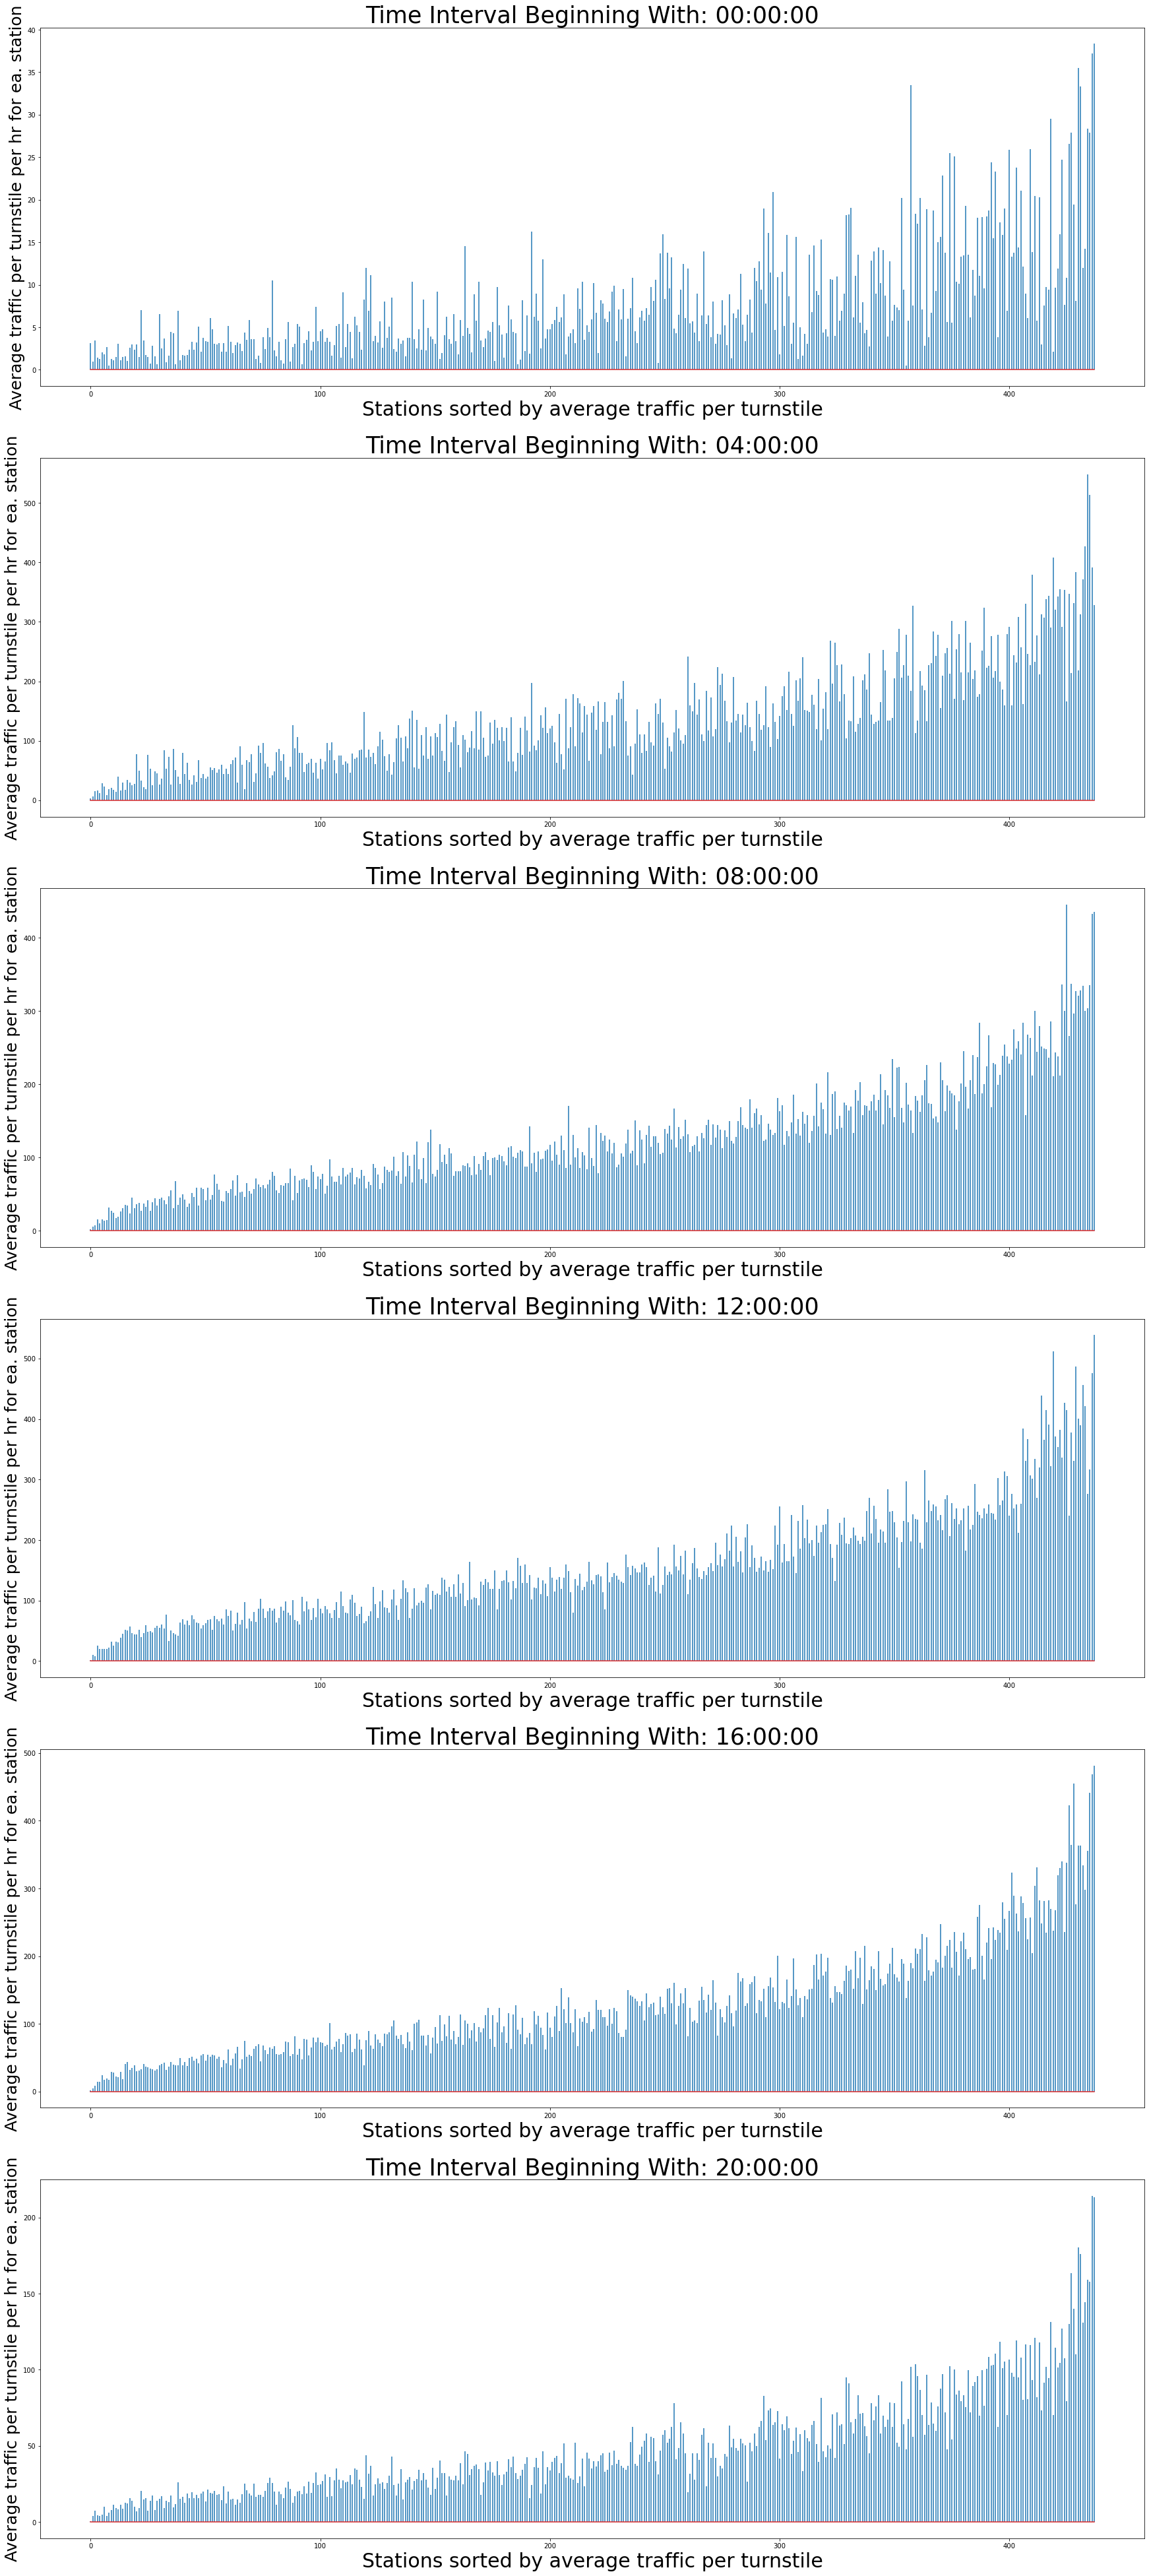

In [1233]:
#Average traffic per hour per turnstile in a station, plotted in datetime slots, w/
# stations sorted by total weekly traffic
col_nums = 1  # how many plots per row
row_nums = ceil(len(tst2_wk_avg) / col_nums)  # how many rows of plots
plt.figure(figsize=(30,70))  # change the figure size as needed
for i, (k, v) in enumerate(tst2_wk_avg.items(), 1):
    plt.subplot(row_nums, col_nums, i)  # create subplots
    sub_v = v['avg_traffic']
    p = plt.stem(sub_v, markerfmt=' ', use_line_collection=True)
    plt.title(f'Time Interval Beginning With: {k}', fontsize=35)
    plt.ylabel('Average traffic per turnstile per hr for ea. station', fontsize = 25)
    plt.xlabel('Stations sorted by average traffic per turnstile', fontsize = 30)

# plt.tight_layout()
plt.show()


In [12]:
dst3 = dens2_stats.query('datetime.time(4) <= time < datetime.time(20)')

t = dst3.groupby(['week_end','suid'])[['total_traffic']].mean()#.reset_index(level='suid')

a = dst3.groupby(['week_end','suid'])[['avg_traffic']].mean()#.reset_index(level='suid')
dst3 = t.merge(a, left_index=True, right_index=True).reset_index(level='suid')

dst3_tot_wk = dst3.loc['week'].sort_values('total_traffic').set_index('suid')
dst3_tot_wknd = dst3.loc['weekend'].sort_values('total_traffic').set_index('suid')
dst3_avg_wk = dst3.loc['week'].sort_values('avg_traffic').set_index('suid')
dst3_avg_wknd = dst3.loc['weekend'].sort_values('avg_traffic').set_index('suid')

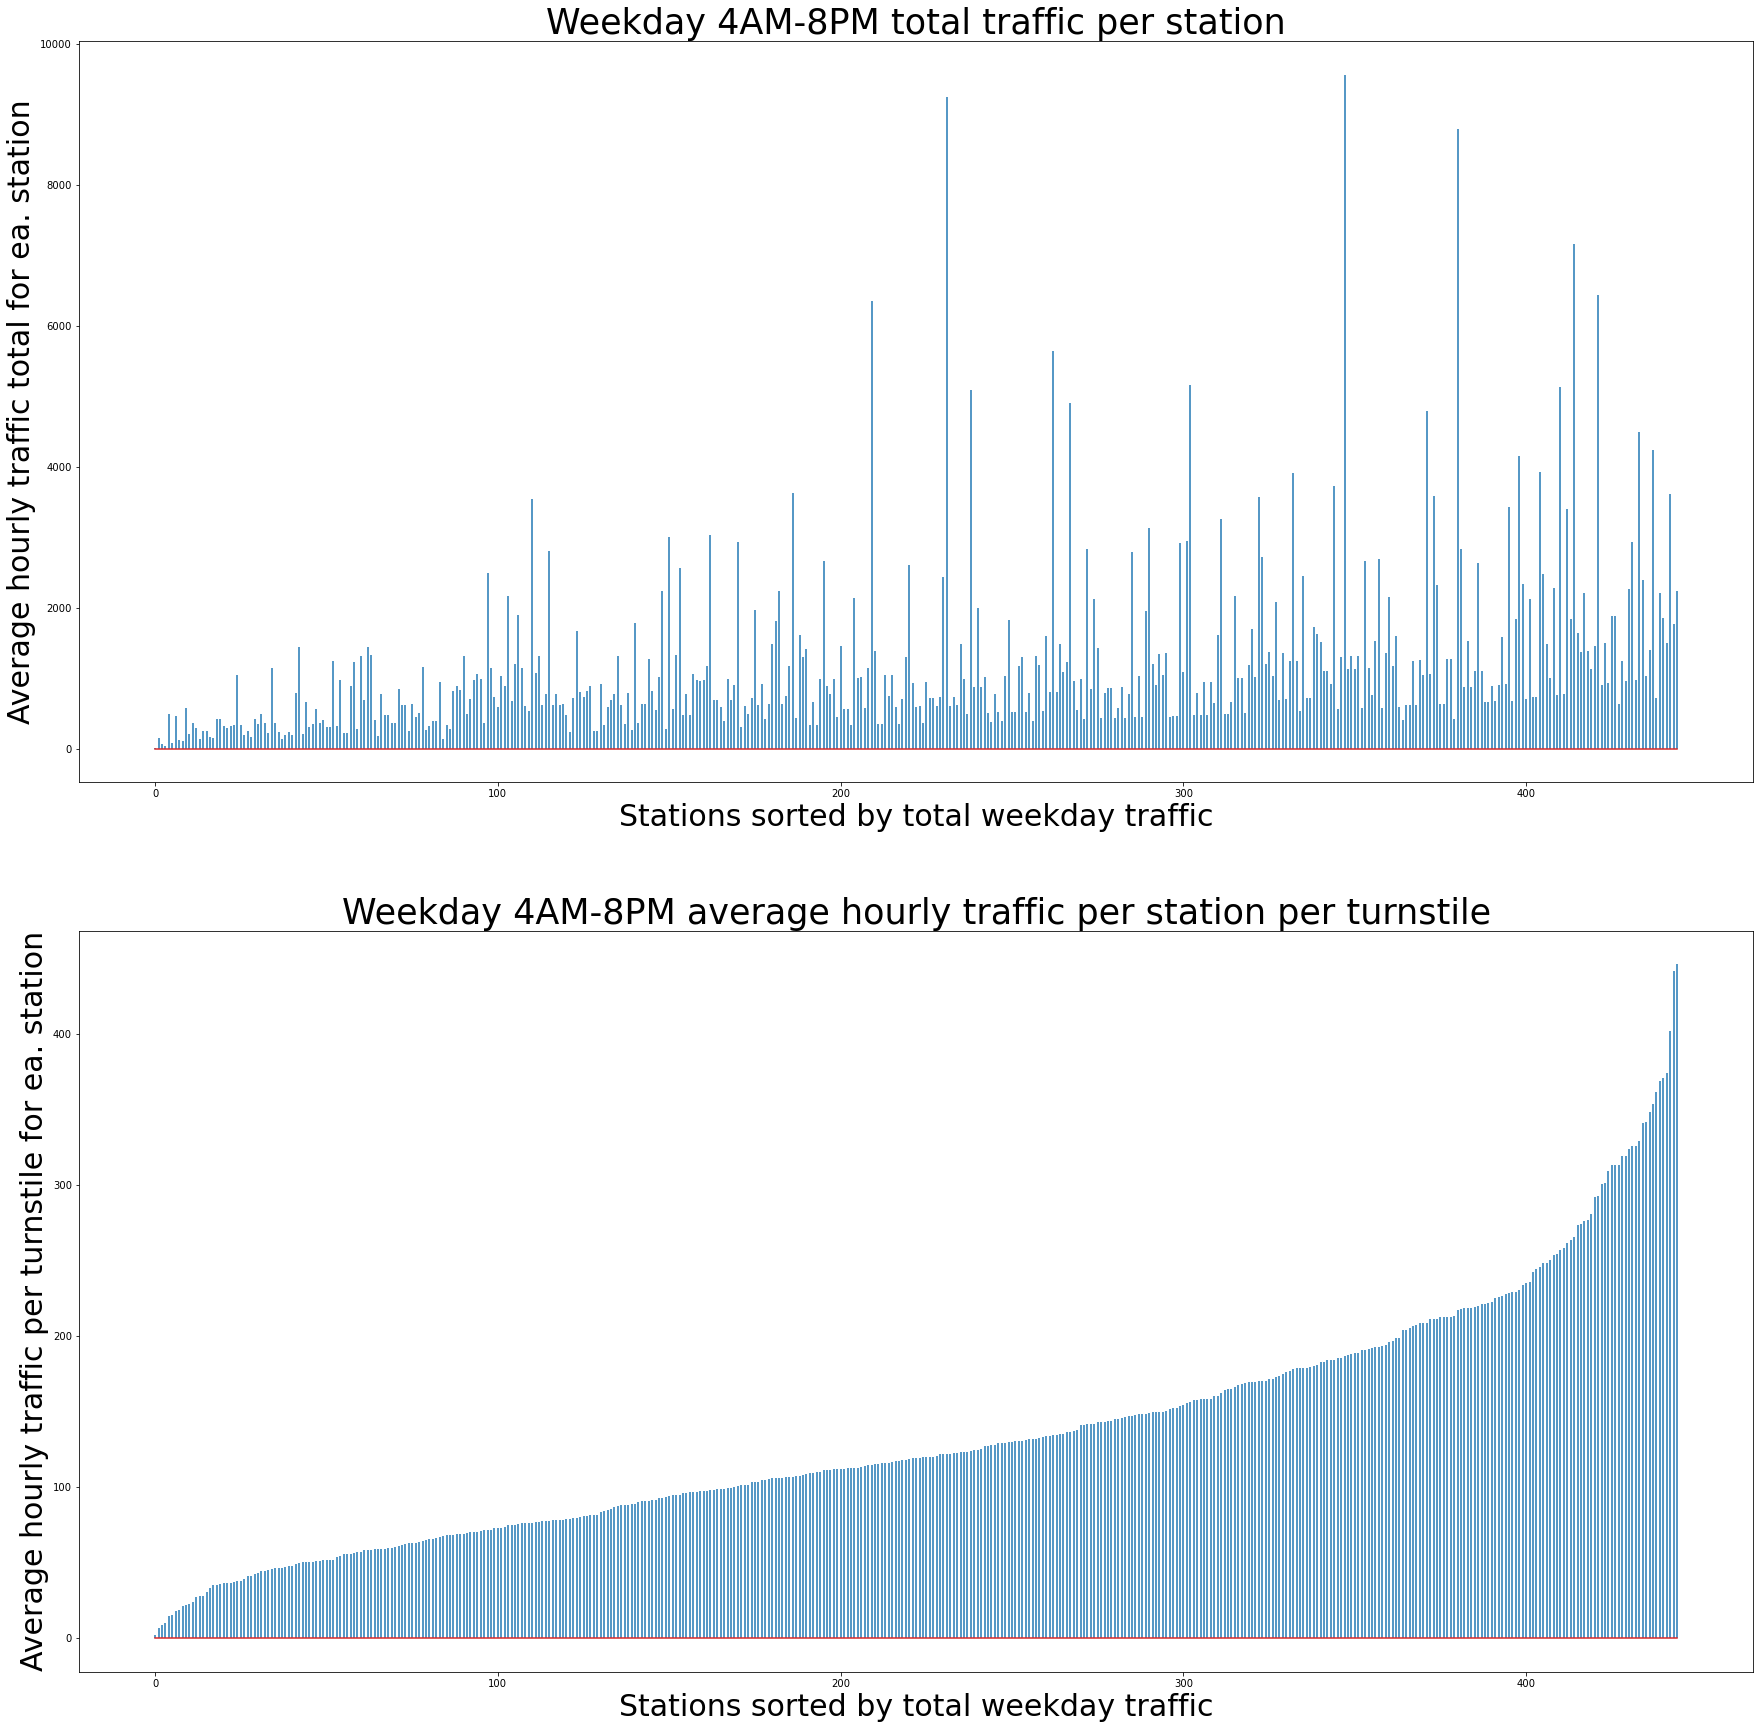

In [1480]:
plt.figure(figsize = (30,30))

plt.subplot(2, 1, 1)
p = plt.stem(dst3_avg_wk['total_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekday 4AM-8PM total traffic per station', fontsize=35)
plt.ylabel('Average hourly traffic total for ea. station', fontsize = 30)
plt.xlabel('Stations sorted by total weekday traffic', fontsize = 30)

plt.subplot(2, 1, 2)
p = plt.stem(dst3_avg_wk['avg_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekday 4AM-8PM average hourly traffic per station per turnstile', fontsize=35)
plt.ylabel('Average hourly traffic per turnstile for ea. station', fontsize = 30)
plt.xlabel('Stations sorted by total weekday traffic', fontsize = 30)

plt.show()

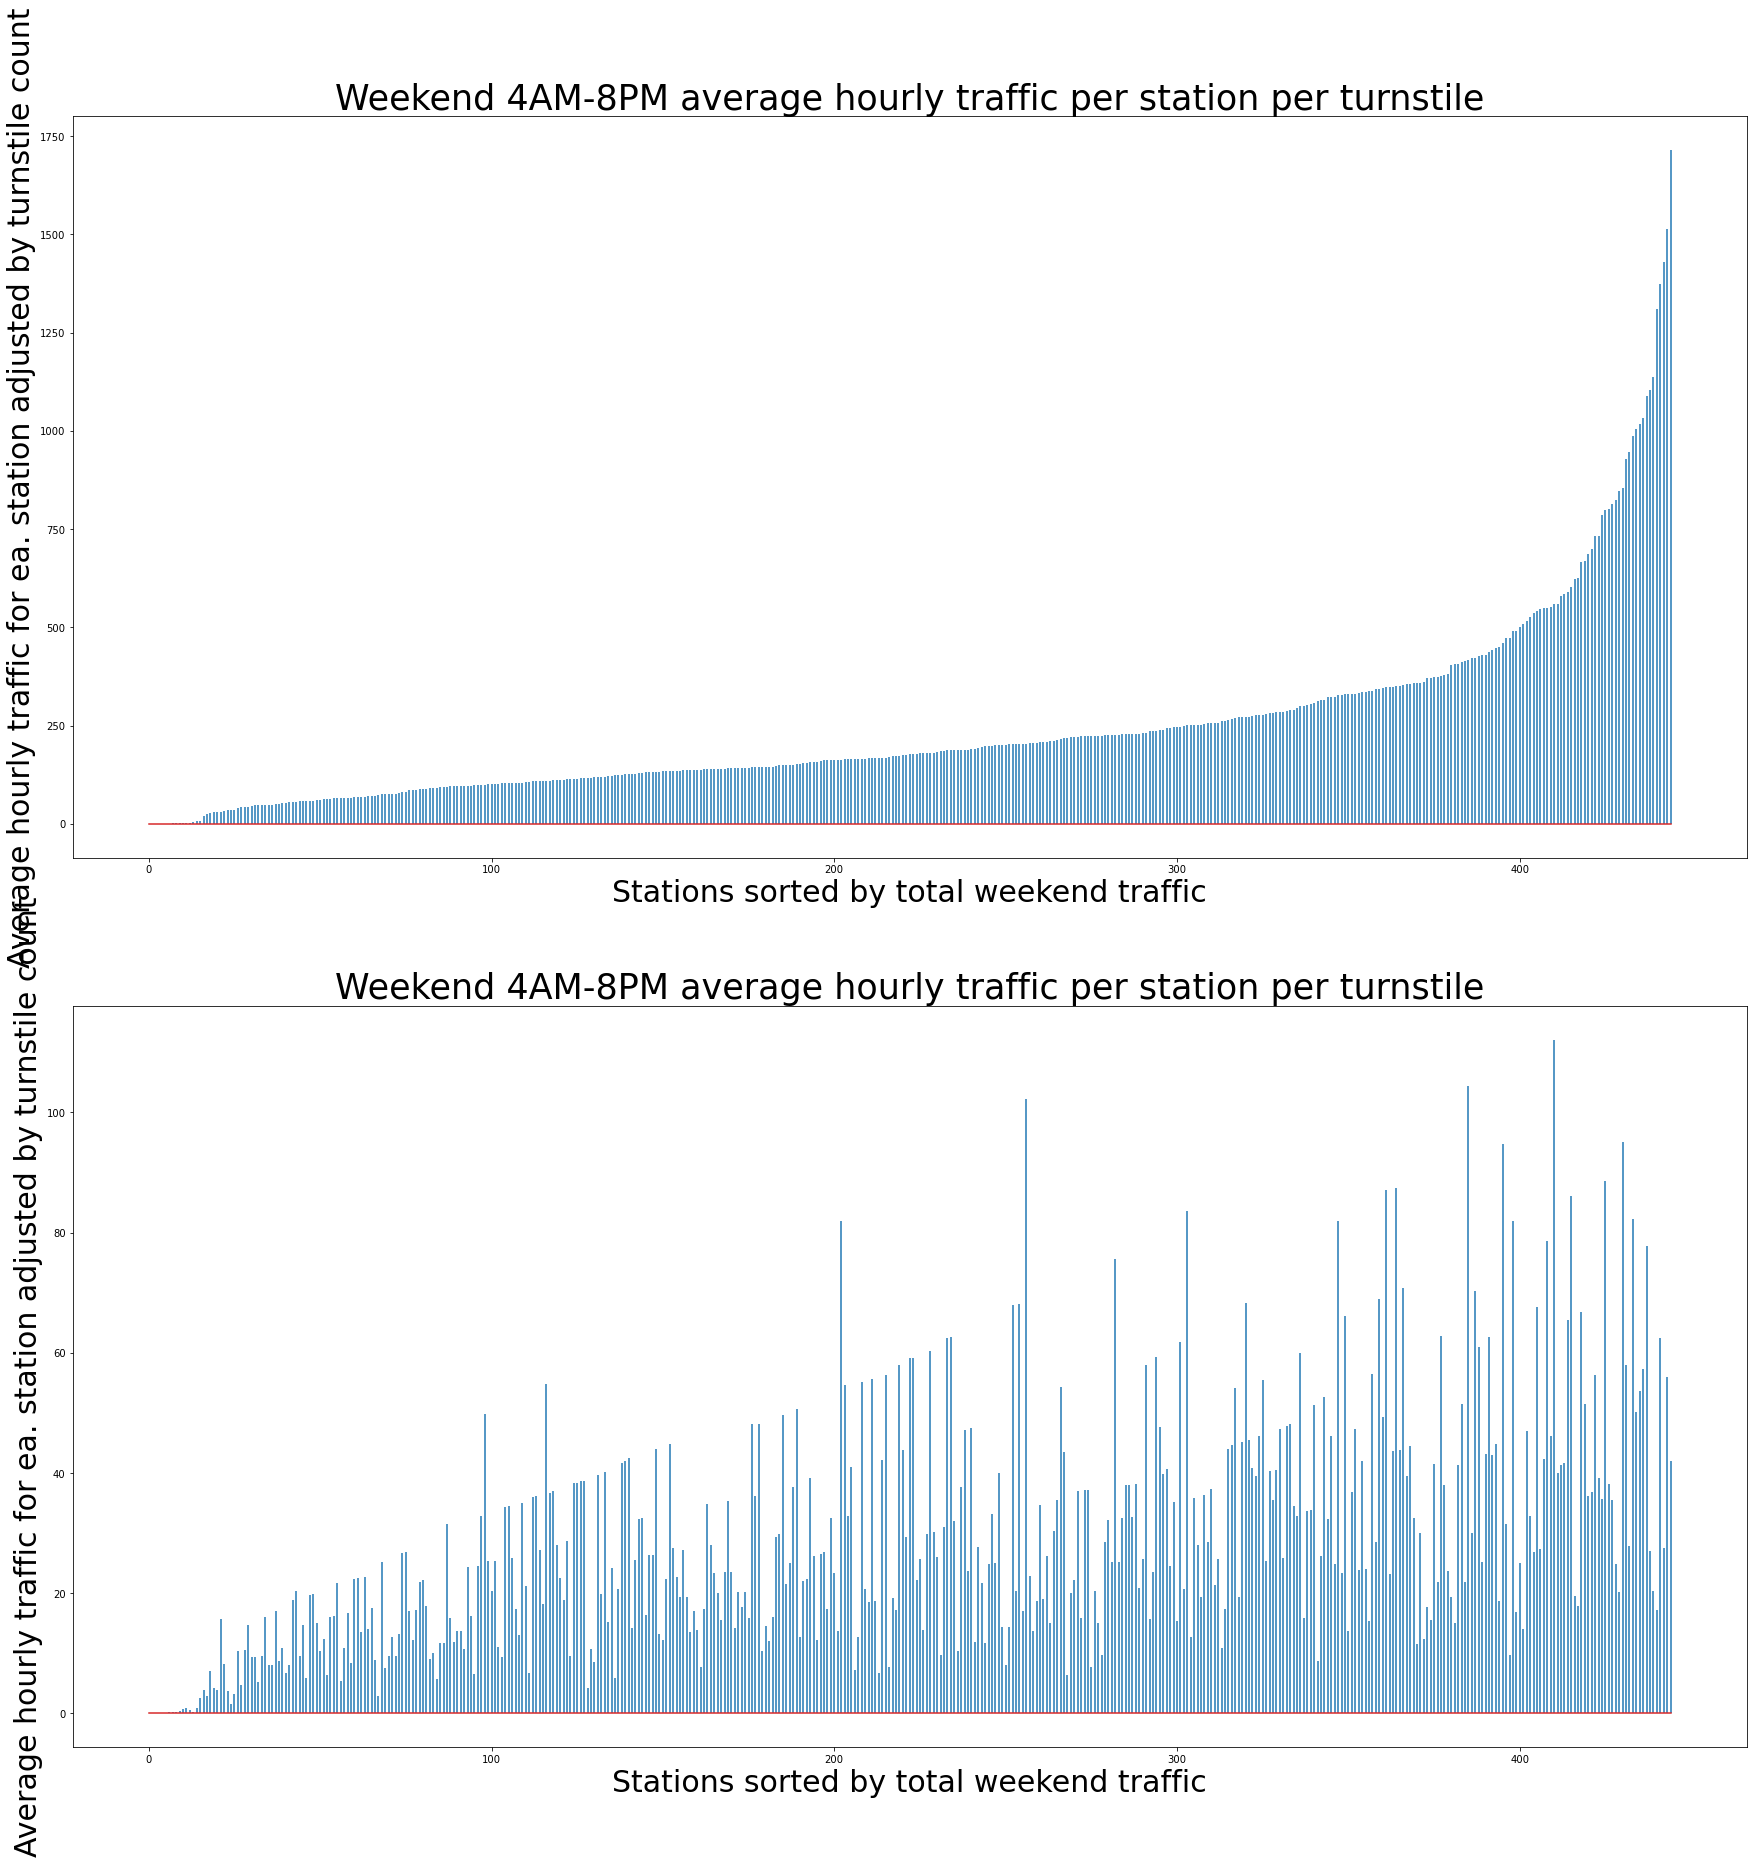

In [1395]:
plt.figure(figsize = (30,30))

plt.subplot(2, 1, 1)
p = plt.stem(dst3_tot_wknd['total_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekend 4AM-8PM average hourly traffic per station per turnstile', fontsize=35)
plt.ylabel('Average hourly traffic for ea. station adjusted by turnstile count', fontsize = 30)
plt.xlabel('Stations sorted by total weekend traffic', fontsize = 30)

plt.subplot(2, 1, 2)
p = plt.stem(dst3_tot_wknd['avg_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekend 4AM-8PM average hourly traffic per station per turnstile', fontsize=35)


plt.show()

In [13]:
dens4_stats = dens2[[*dens2.columns[0:4],*dens2.columns[8:]]].drop_duplicates()

#aggregate by day, separating weekend
dens4_stats['week_end'] = dens4_stats['datetime'].dt.dayofweek.apply(lambda x: 'weekend' if  x >= 5 else 'week')
dens4_stats = dens4_stats.groupby(['complex_id', 'week_end', 'time'])[['total_traffic', 'avg_traffic']].sum().reset_index()

In [1466]:
dst3['avg_tot'] = dst3['total_traffic'] / dst3['avg_traffic'] 

In [14]:
dst3_tot_wk = dst3.loc['week'].sort_values('total_traffic').set_index('suid')
dst3_tot_wknd = dst3.loc['weekend'].sort_values('total_traffic').set_index('suid')
dst3_avg_wk = dst3.loc['week'].sort_values('avg_traffic').set_index('suid')
dst3_avg_wknd = dst3.loc['weekend'].sort_values('avg_traffic').set_index('suid')

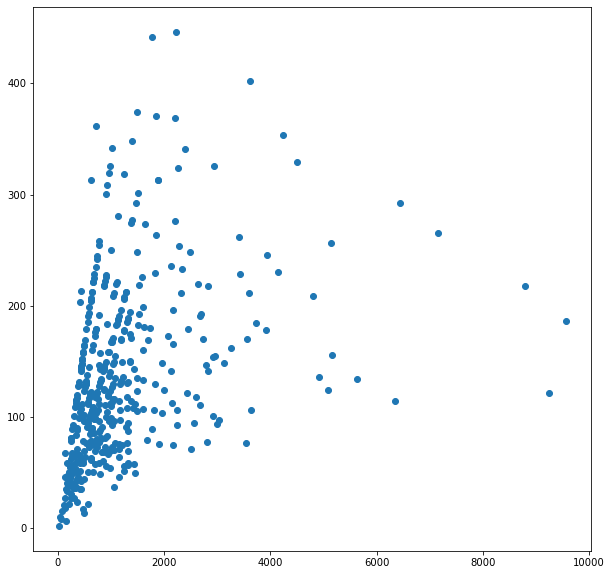

In [1460]:
plt.figure(figsize = (10,10))
plt.scatter(dst3_tot_wk['total_traffic'], dst3_tot_wk['avg_traffic'])
plt.show()

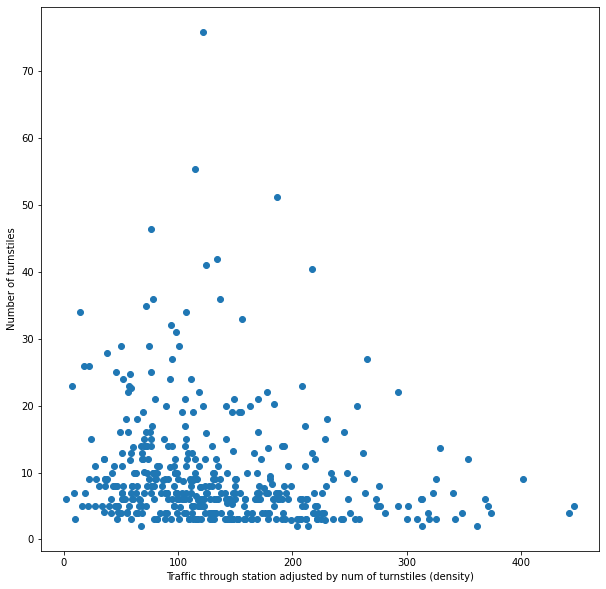

In [1474]:
plt.figure(figsize = (10,10))
plt.scatter(dst3_tot_wk['avg_traffic'], dst3_tot_wk['avg_tot'])
plt.ylabel('Number of turnstiles')
plt.xlabel('Traffic through station adjusted by num of turnstiles (density)')
plt.show()

In [15]:
dst4 = dens2_stats.query('datetime.time(4) <= time < datetime.time(20)')

t = dst4.groupby(['week_end','suid'])[['total_traffic']].mean()#.reset_index(level='suid')

a = dst4.groupby(['week_end','suid'])[['avg_traffic']].mean()#.reset_index(level='suid')
dst4 = t.merge(a, left_index=True, right_index=True).reset_index(level='suid')

dst4_tot_wk = dst4.loc['week'].sort_values('total_traffic').set_index('suid')
dst3_tot_wknd = dst4.loc['weekend'].sort_values('total_traffic').set_index('suid')
dst4_avg_wk = dst4.loc['week'].sort_values('avg_traffic').set_index('suid')
dst3_avg_wknd = dst4.loc['weekend'].sort_values('avg_traffic').set_index('suid')

In [1562]:
dst4_tot_wk['total_traffic'].iloc[395]

32868.0

dst4_avg_wk['avg_traffic'].iloc[344]

In [1526]:
dst4_avg_wk.query('avg_traffic > 866')

,total_traffic,avg_traffic
suid,,
51,6928.0625,866.007812
25,2599.4375,866.479167
197,8716.7500,871.675000
464,3492.2500,873.062500
329,5244.0000,874.000000
...,...,...
344,427769.6250,5635.736974
215,132661.0625,6030.048295
434,181645.3750,6727.606481


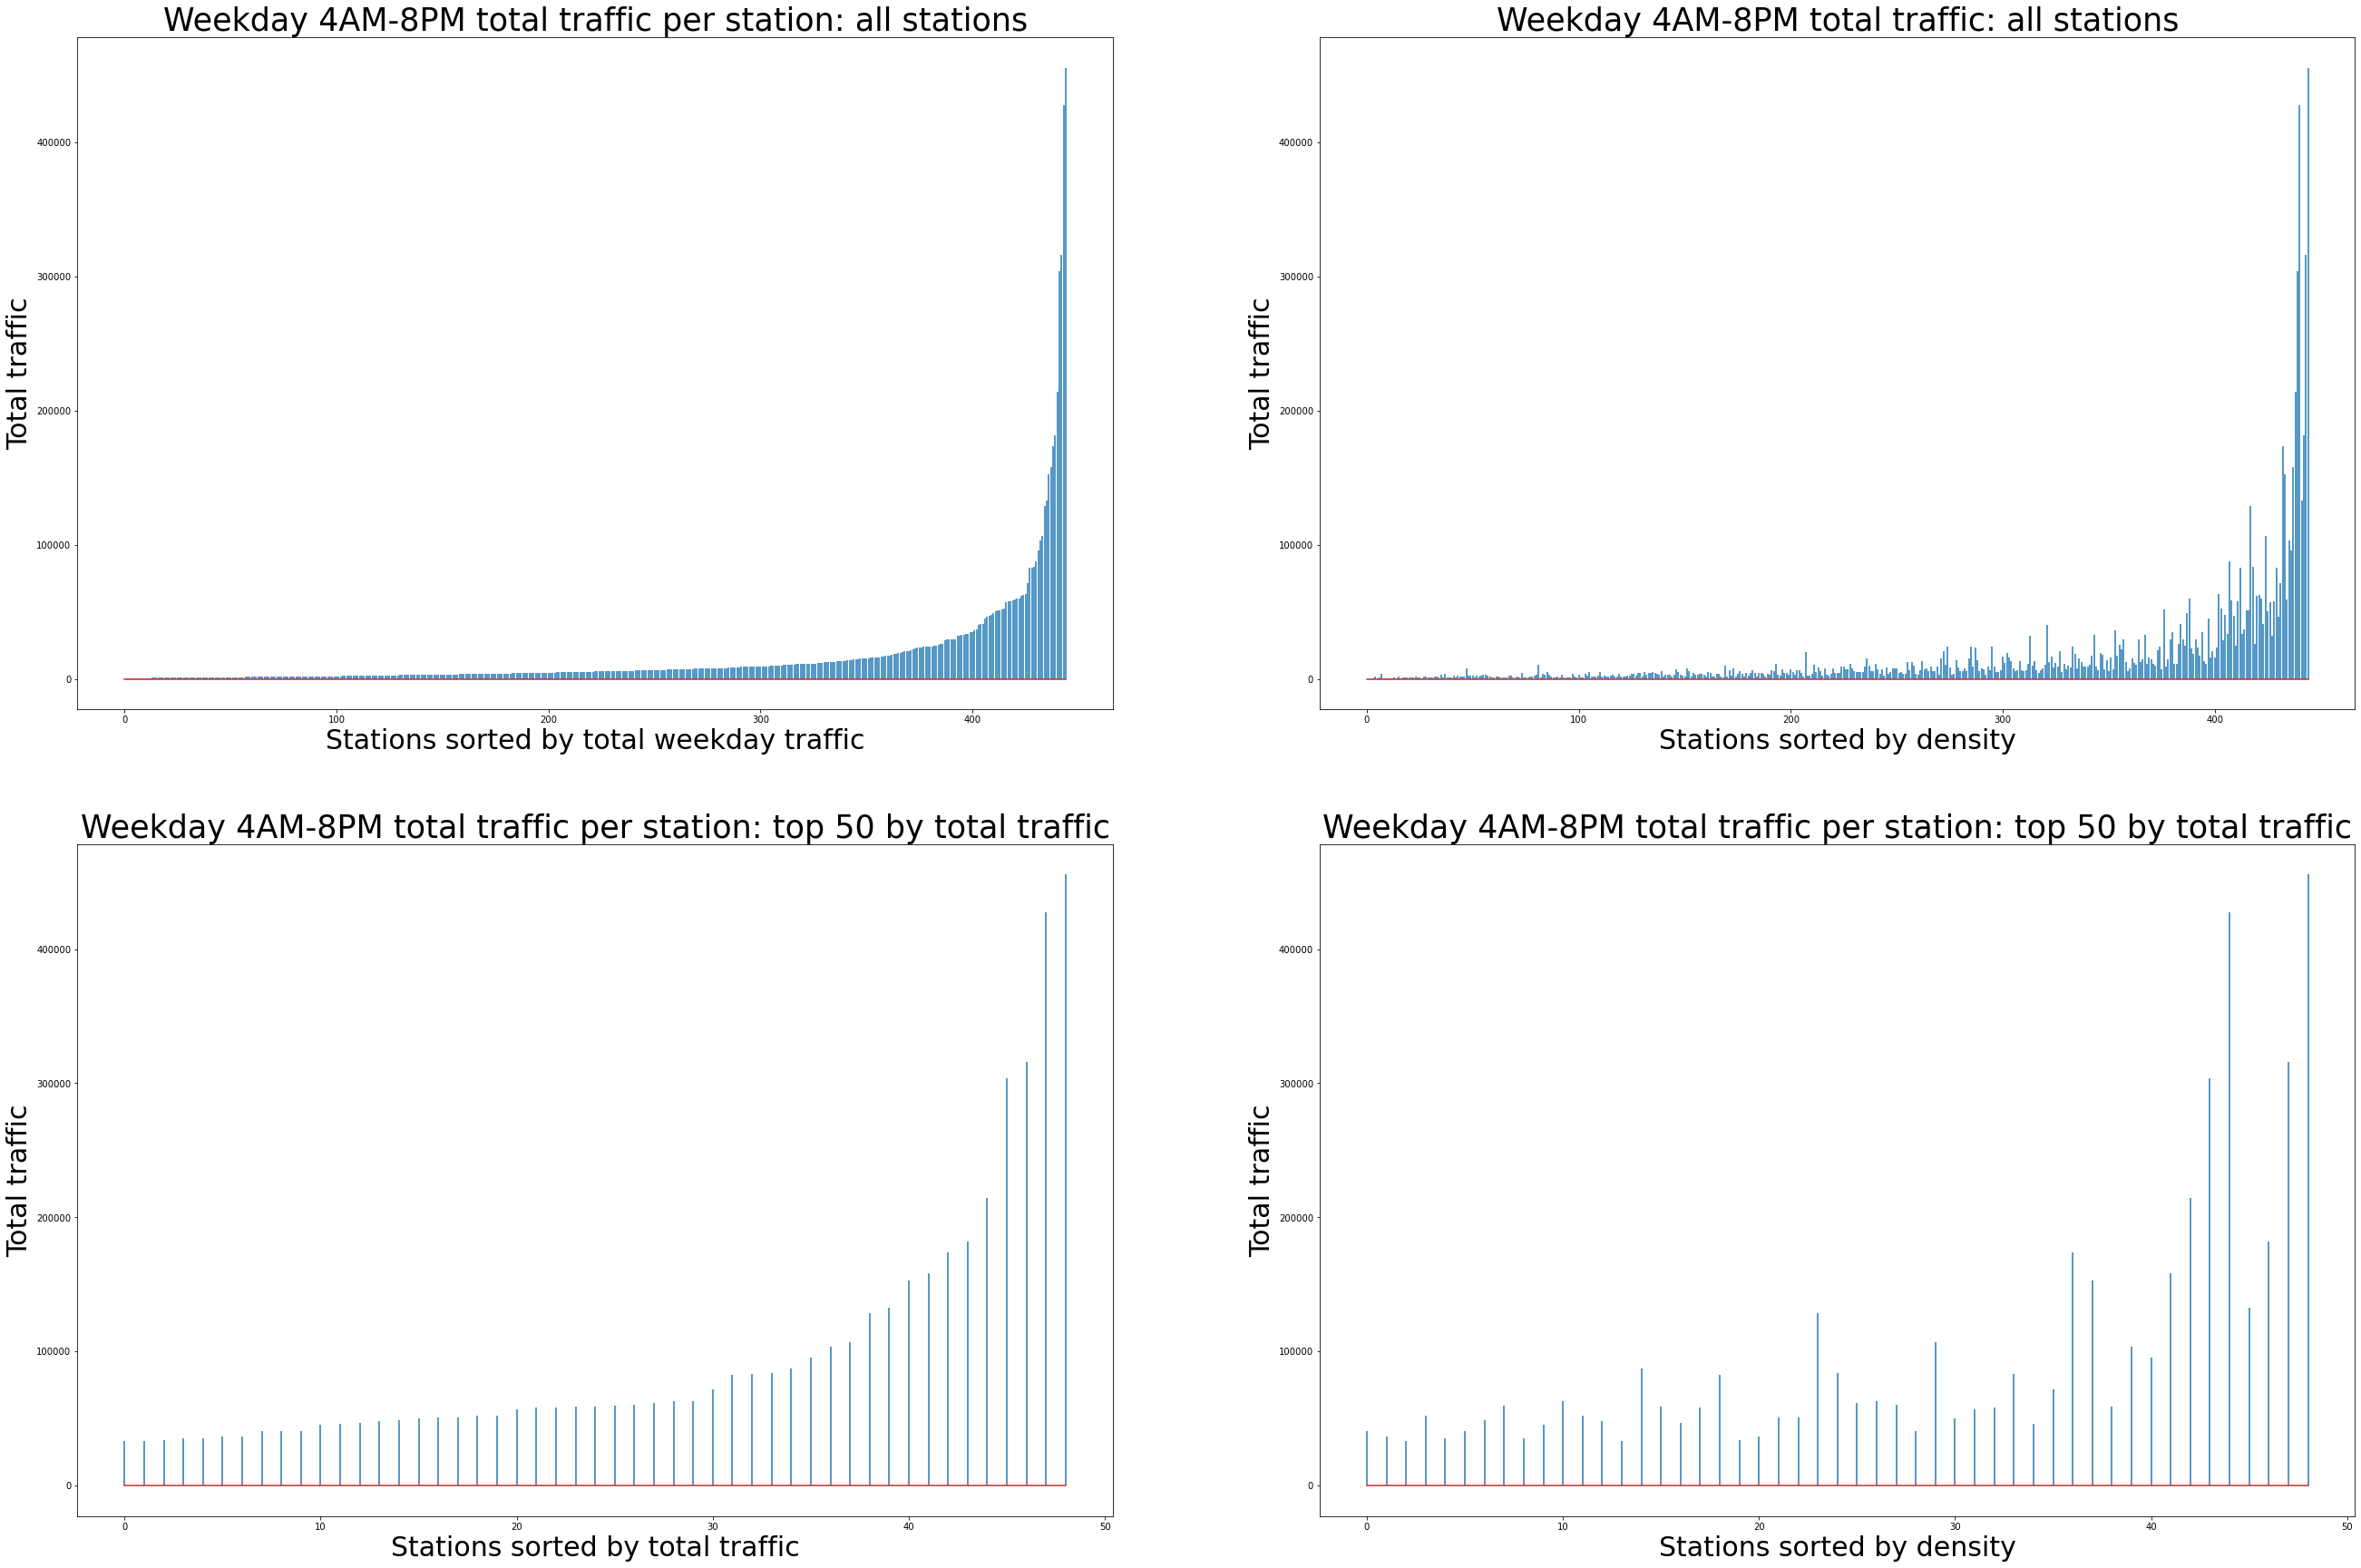

In [1566]:
plt.figure(figsize = (45,30))
dst4_tot_wk200 = dst4_tot_wk.query('total_traffic > 32868')
dst4_avg_wk200 = dst4_avg_wk.query('total_traffic > 32868')
plt.subplot(2, 2, 1)
p = plt.stem(dst4_tot_wk['total_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekday 4AM-8PM total traffic per station: all stations', fontsize=35)
plt.ylabel('Total traffic', fontsize = 30)
plt.xlabel('Stations sorted by total weekday traffic', fontsize = 30)

plt.subplot(2, 2, 2)
p = plt.stem(dst4_avg_wk['total_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekday 4AM-8PM total traffic: all stations', fontsize=35)
plt.ylabel('Total traffic', fontsize = 30)
plt.xlabel('Stations sorted by density', fontsize = 30)

plt.subplot(2, 2, 3)
p = plt.stem(dst4_tot_wk200['total_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekday 4AM-8PM total traffic per station: top 50 by total traffic', fontsize=35)
plt.ylabel('Total traffic', fontsize = 30)
plt.xlabel('Stations sorted by total traffic', fontsize = 30)

plt.subplot(2, 2, 4)
p = plt.stem(dst4_avg_wk200['total_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekday 4AM-8PM total traffic per station: top 50 by total traffic', fontsize=35)
plt.ylabel('Total traffic', fontsize = 30)
plt.xlabel('Stations sorted by density', fontsize = 30)

plt.show()

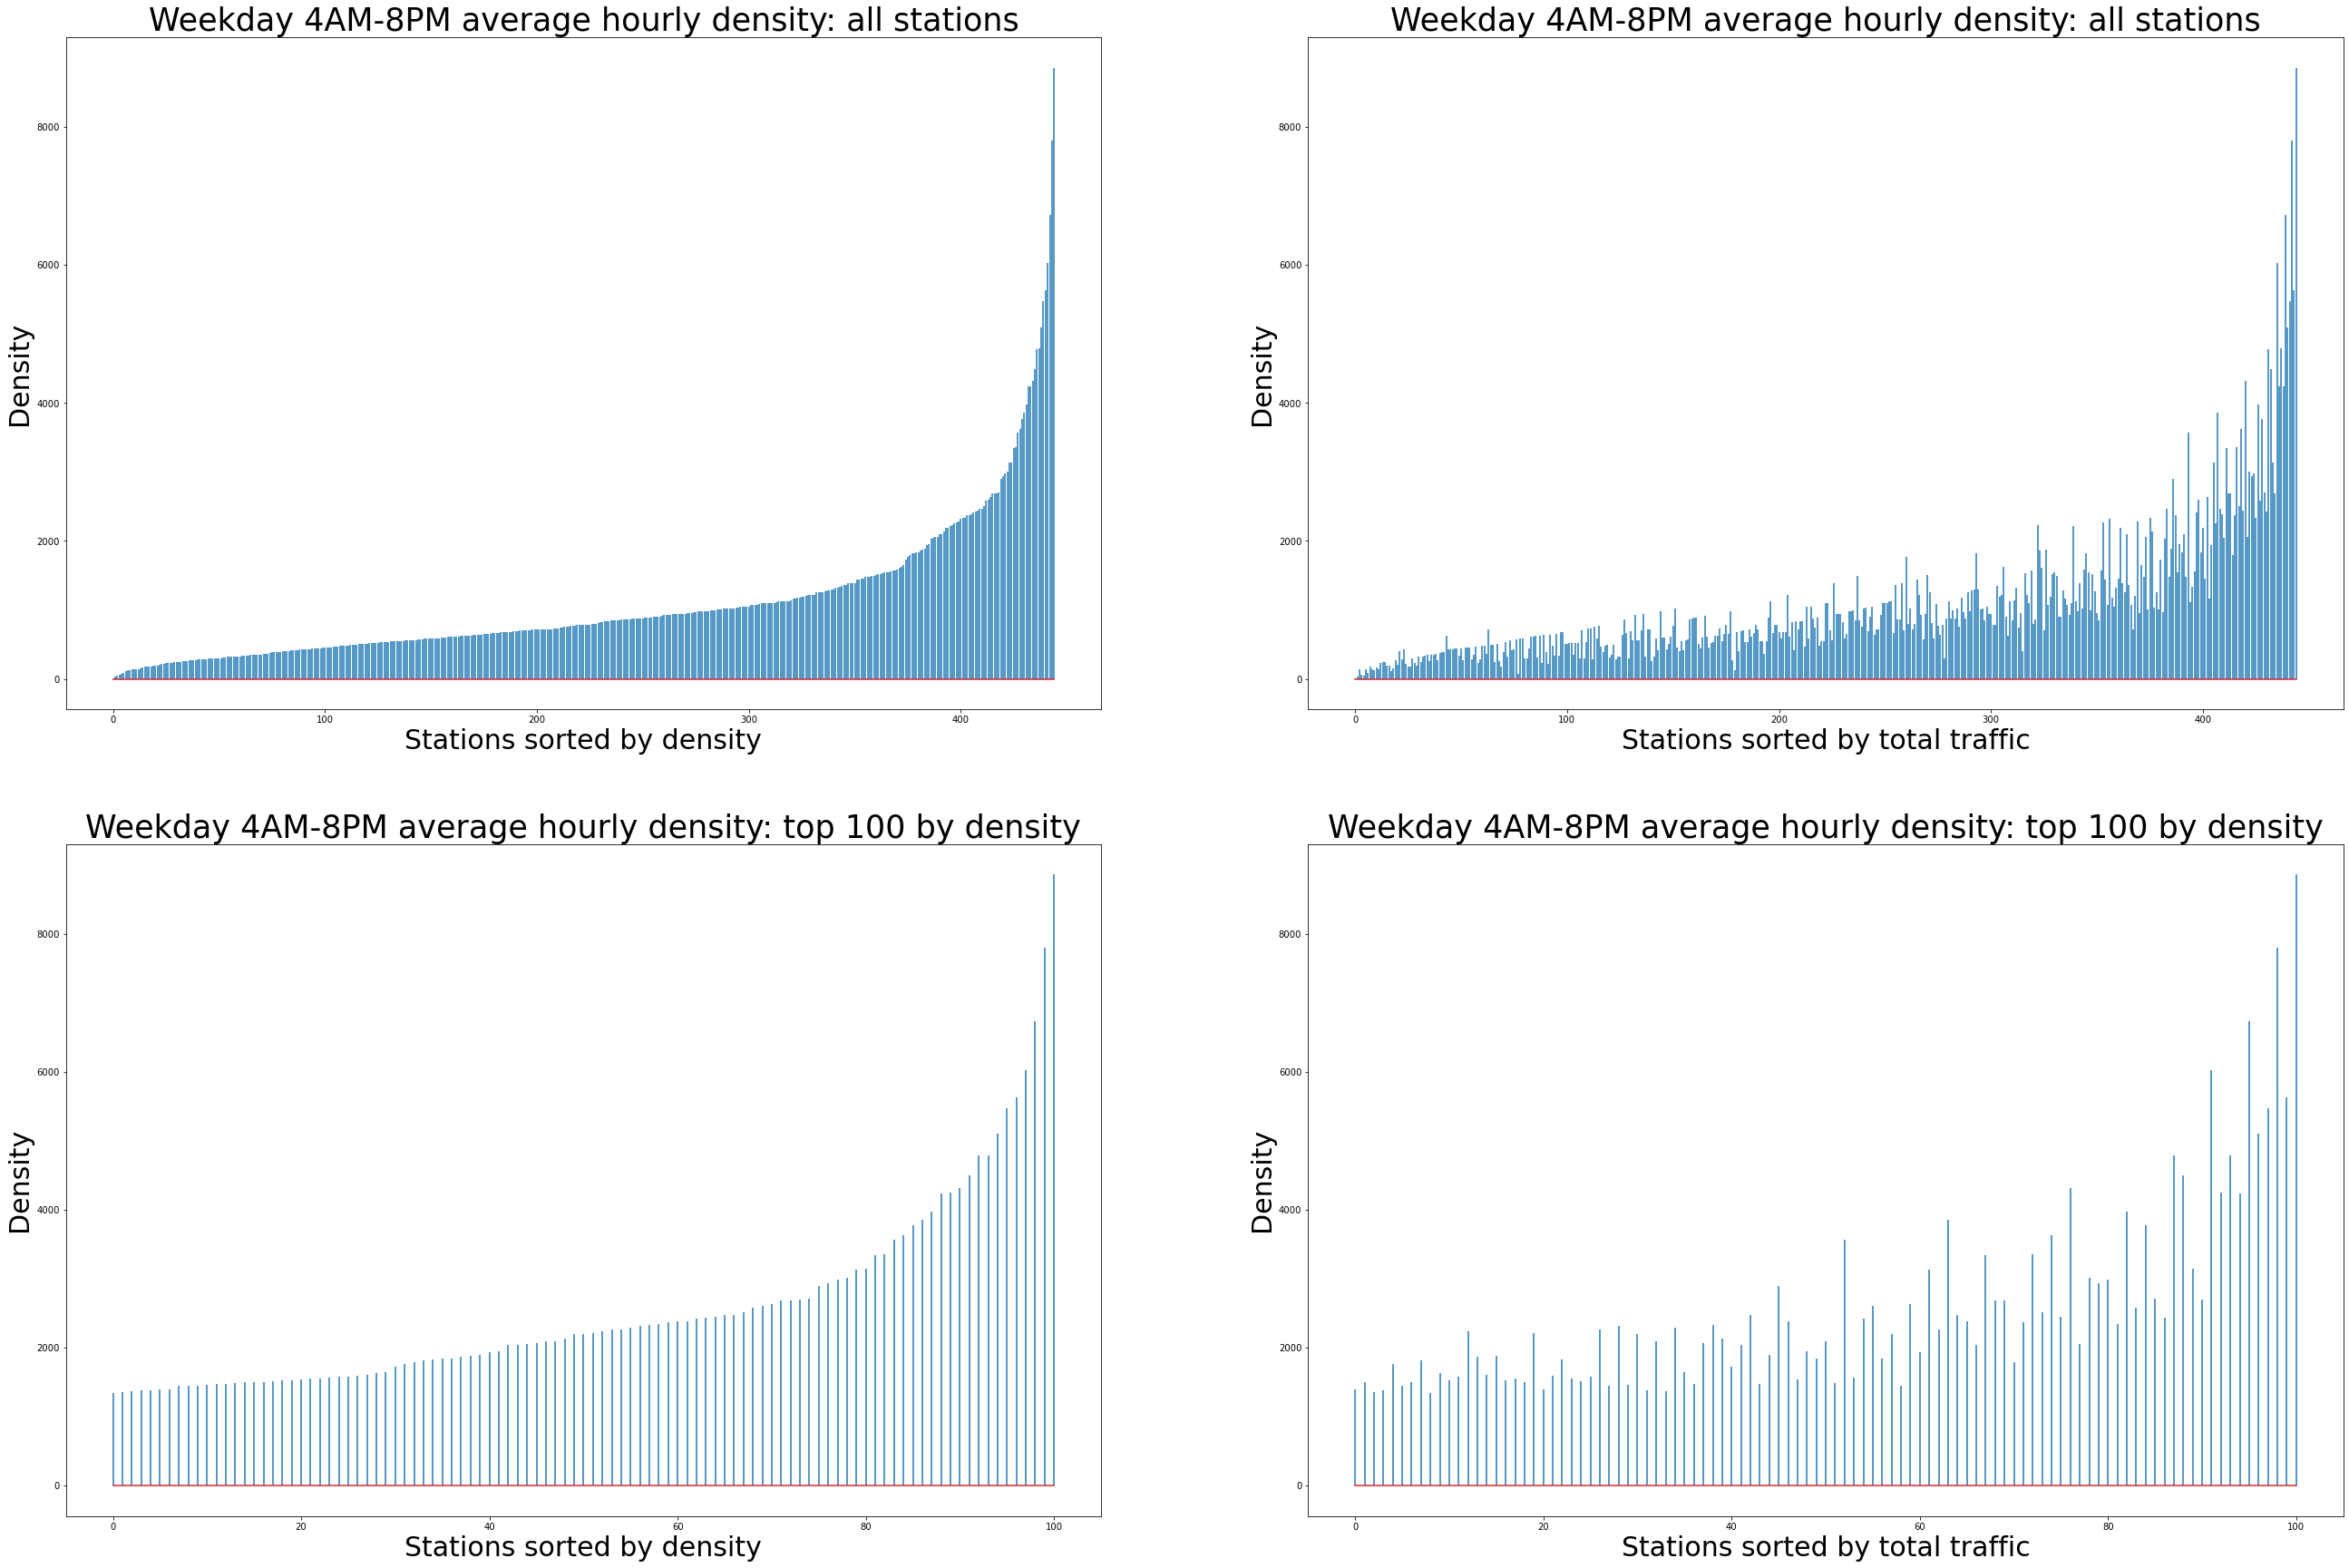

In [1565]:
dst4_tot_wk200_2 = dst4_tot_wk.query('avg_traffic > 1349')
dst4_avg_wk200_2 = dst4_avg_wk.query('avg_traffic > 1349')
plt.figure(figsize = (45,30))
# dst4_tot_wk = dst4_tot_wk.query('total_traffic > 5412')
# dst4_avg_wk = dst4_avg_wk.query('avg_traffic > 866')
plt.subplot(2, 2, 2)
p = plt.stem(dst4_tot_wk['avg_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekday 4AM-8PM average hourly density: all stations', fontsize=35)
plt.ylabel('Density', fontsize = 30)
plt.xlabel('Stations sorted by total traffic', fontsize = 30)

plt.subplot(2, 2, 1)
p = plt.stem(dst4_avg_wk['avg_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekday 4AM-8PM average hourly density: all stations', fontsize=35)
plt.ylabel('Density', fontsize = 30)
plt.xlabel('Stations sorted by density', fontsize = 30)

plt.subplot(2, 2, 4)
p = plt.stem(dst4_tot_wk200_2['avg_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekday 4AM-8PM average hourly density: top 100 by density', fontsize=35)
plt.ylabel('Density', fontsize = 30)
plt.xlabel('Stations sorted by total traffic', fontsize = 30)

plt.subplot(2, 2, 3)
p = plt.stem(dst4_avg_wk200_2['avg_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Weekday 4AM-8PM average hourly density: top 100 by density', fontsize=35)
plt.ylabel('Density', fontsize = 30)
plt.xlabel('Stations sorted by density', fontsize = 30)

plt.show()

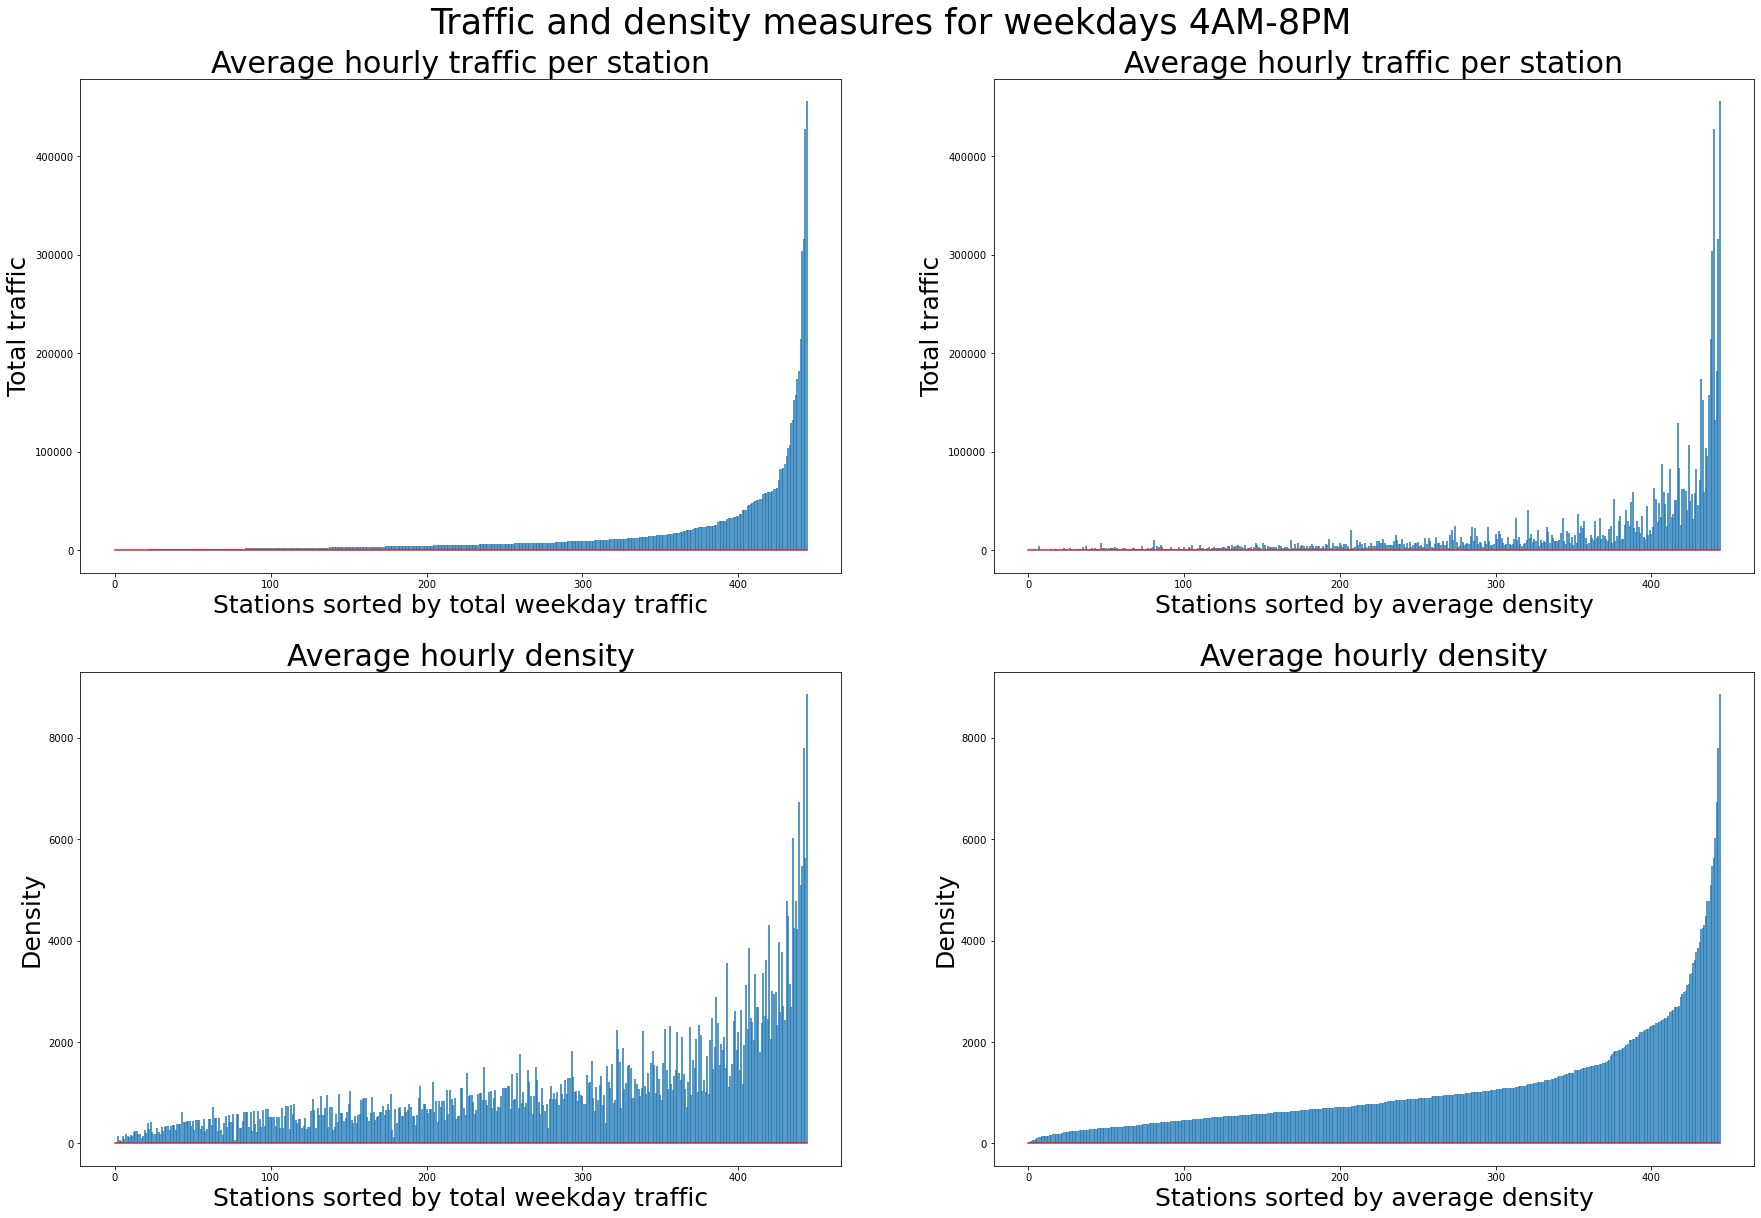

In [30]:
plt.figure(figsize = (30,20))
plt.suptitle('Traffic and density measures for weekdays 4AM-8PM', y=0.93, fontsize=35)
plt.subplot(2, 2, 1)
p = plt.stem(dst4_tot_wk['total_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Average hourly traffic per station', fontsize=30)
plt.ylabel('Total traffic', fontsize = 25)
plt.xlabel('Stations sorted by total weekday traffic', fontsize = 25)

plt.subplot(2, 2, 2)
p = plt.stem(dst4_avg_wk['total_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Average hourly traffic per station', fontsize=30)
plt.ylabel('Total traffic', fontsize = 25)
plt.xlabel('Stations sorted by average density', fontsize = 25)

plt.subplot(2, 2, 3)
p = plt.stem(dst4_tot_wk['avg_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Average hourly density', fontsize=30)
plt.ylabel('Density', fontsize = 25)
plt.xlabel('Stations sorted by total weekday traffic', fontsize = 25)

plt.subplot(2, 2, 4)
p = plt.stem(dst4_avg_wk['avg_traffic'], markerfmt=' ', use_line_collection=True)
plt.title('Average hourly density', fontsize=30)
plt.ylabel('Density', fontsize = 25)
plt.xlabel('Stations sorted by average density', fontsize = 25)

plt.show()